# Project-3. EDA + Feature Engineering 

**Главная задача — добиться максимальной точности модели, которая предсказывает рейтинг отеля.**

**Информация о данных:**
датасет для обучения - hotels_train;
датасет для предсказания - hotels_test.


**Наименование столбцов:**

hotel_address — адрес отеля;

review_date — дата, когда рецензент разместил соответствующий отзыв;

average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;

hotel_name — название отеля;

reviewer_nationality — страна рецензента;

negative_review — отрицательный отзыв, который рецензент дал отелю;

review_total_negative_word_counts — общее количество слов в отрицательном отзыв;

positive_review — положительный отзыв, который рецензент дал отелю;

review_total_positive_word_counts — общее количество слов в положительном отзыве;

reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;

total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;

total_number_of_reviews — общее количество действительных отзывов об отеле;

tags — теги, которые рецензент дал отелю;

days_since_review — количество дней между датой проверки и датой очистки;

additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки;

lat — географическая широта отеля;

lng — географическая долгота отеля.

Оглавление:
1. Загрузка и знакомство с данными

2. Подготовка данных для модели

3. Обучение модели

**Загрузка библиотек и интструментов**

In [4]:
import numpy as np
import pandas as pd 

# Импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

 # Загружаем специальный удобный инструмент для расчетов
from scipy import stats

# Загружаем специальный инструмент для проведения нормализации
from sklearn import preprocessing

 # Загружаем специальный удобный инструмент для проверки гипотезы
from scipy.stats import f_oneway

# Импортируем библиотеку для работы с кодировщиками
import category_encoders as ce

# Загружаем специальный удобный инструмент для оценки значимости
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova


# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

In [99]:
# Фиксируйте RANDOM_SEED, чтобы эксперименты были воспроизводимы!
RANDOM_SEED = 42

# **1. Загрузка и знакомство с данными**

In [100]:
# Подгрузим наши данные
hotels_data = pd.read_csv('hotels.csv')
data = hotels_data.copy()
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

Данный состоят из object, int64, float64. В таблице 386803 строк и 17 столбцов. В столбцах lat и lng присутствуют пропуски.

# **2. Подготовка данных для модели**

# Очистка данных

**Работа с выбросами**

Среди всех признаков на выбросы решила проверить "количество отзывов, которые рецензенты дали в прошлом" и "количество оценок без отзывов",так как в данных признаках сложно будет логически объяснить аномалию. В то время как в других признаках возможно объяснение нестандартных значений. 

count    386803.00000
mean          7.17725
std          11.05442
min           1.00000
25%           1.00000
50%           3.00000
75%           8.00000
max         355.00000
Name: total_number_of_reviews_reviewer_has_given, dtype: float64

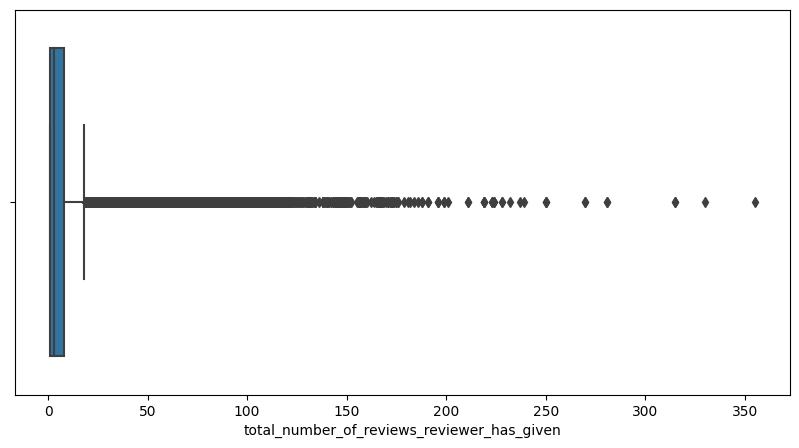

In [102]:
# Проверим признак "количество отзывов, которые рецензенты дали в прошлом" на наличие выбросов
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 5))
display(data['total_number_of_reviews_reviewer_has_given'].describe())
sns.boxplot(data=data, x='total_number_of_reviews_reviewer_has_given');

В данном столбце есть выбросы. Сомневаюсь, что кто-то постоянно живет по несколько дней в разных отелях и пишет на каждый отзыв. Удалим их из датасета.

count    386070.000000
mean        498.480716
std         500.406014
min           1.000000
25%         169.000000
50%         342.000000
75%         660.000000
max        2682.000000
Name: additional_number_of_scoring, dtype: float64

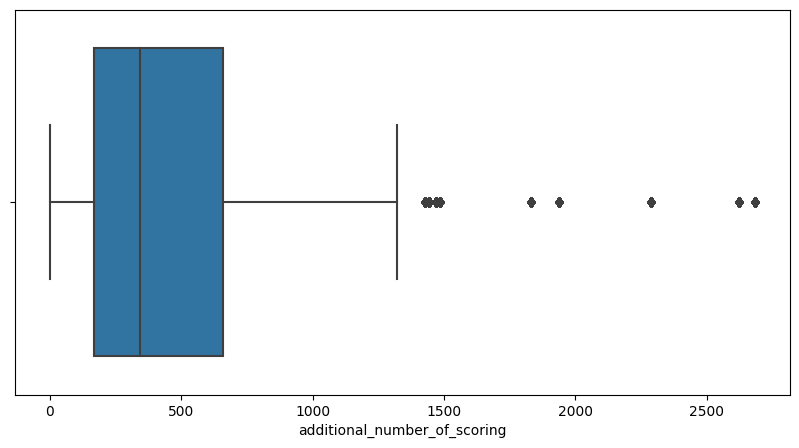

In [103]:
# Удаляем выбросы
data = data[data['total_number_of_reviews_reviewer_has_given'] < 90]

# Проверим признак "количество оценок без отзывов" на наличие выбросов
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 5))
display(data['additional_number_of_scoring'].describe())
sns.boxplot(data=data, x='additional_number_of_scoring');

Есть слишком большие значения оценок без комментариев. Думаю стоит их убрать, чтобы не сбивали модель.

In [104]:
# Удаляем выбросы
data = data[data['additional_number_of_scoring'] < 1400]

**Работа с дубликатами**

In [105]:
# Найдем дубликаты в датасете
dupl_columns = list(data.columns) 
mask = data.duplicated(subset=dupl_columns)
duplicates = data[mask]
print(f'Число найденных дубликатов: {duplicates.shape[0]}')

Число найденных дубликатов: 305


In [106]:
# Удалим дубликаты из датасета
data.drop_duplicates(inplace=True, ignore_index=True) # удаляем дубли

In [107]:
# Посмотрим информацию по датасету после очистки данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363627 entries, 0 to 363626
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               363627 non-null  object 
 1   additional_number_of_scoring                363627 non-null  int64  
 2   review_date                                 363627 non-null  object 
 3   average_score                               363627 non-null  float64
 4   hotel_name                                  363627 non-null  object 
 5   reviewer_nationality                        363627 non-null  object 
 6   negative_review                             363627 non-null  object 
 7   review_total_negative_word_counts           363627 non-null  int64  
 8   total_number_of_reviews                     363627 non-null  int64  
 9   positive_review                             363627 non-null  object 
 

Число строк и столбцов уменьшилось.

**Работа с пропусками**

In [108]:
# Так как в столбцах lat, lng есть пропуски, а так же они дублируют информацию место нахождения отеля 
# из столбца hotel_address удалю их
data.drop(['lat', 'lng'], axis=1 , inplace=True)

**Смотрим уникальность данных**

In [109]:
# Смотрим число уникальных значений всего датасета
data.nunique(dropna=False)

hotel_address                                   1484
additional_number_of_scoring                     471
review_date                                      731
average_score                                     34
hotel_name                                      1483
reviewer_nationality                             225
negative_review                               232871
review_total_negative_word_counts                401
total_number_of_reviews                         1133
positive_review                               294924
review_total_positive_word_counts                351
total_number_of_reviews_reviewer_has_given        89
reviewer_score                                    37
tags                                           45522
days_since_review                                731
dtype: int64

# Работа с датой

In [110]:
 # Преобразуем дату в формат datetime
data['review_date'] = pd.to_datetime(data['review_date'])

# Посмотрим даты самого раннего и самого позднего отзыва
data_min = data['review_date'].min()
data_max = data['review_date'].max()
print(f'Самый свежий отзыв был оставлен {data_max}. Первый отзыв оставлен {data_min}.')

Самый свежий отзыв был оставлен 2017-08-03 00:00:00. Первый отзыв оставлен 2015-08-04 00:00:00.


In [111]:
# Создадим признак "месяц обзора"
data['review_month'] = data['review_date'].dt.month

# Создадим признак "год обзора"
data['review_year'] = data['review_date'].dt.year

# Удалим признак "даты обзора" из данных
data.drop('review_date', axis=1 , inplace=True)

# Псмотрим, что получилось
data.head(3)

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,review_month,review_year
0,Stratton Street Mayfair Westminster Borough Lo...,581,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,2,2016
1,130 134 Southampton Row Camden London WC1B 5AF...,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,1,2017
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,10,2016


# Работа с текстом

**Признак адреса отелей**

In [112]:
# Смотрим уникальные адреса у отелей
data['hotel_address'].value_counts()

1 Inverness Terrace Westminster Borough London W2 3JP United Kingdom      2218
Wrights Lane Kensington and Chelsea London W8 5SP United Kingdom          2095
1 Waterview Drive Greenwich London SE10 0TW United Kingdom                1938
27 Devonshire Terrace Westminster Borough London W2 3DP United Kingdom    1733
1 Addington Street Lambeth London SE1 7RY United Kingdom                  1695
                                                                          ... 
40 Rue Rene Boulanger 10th arr 75010 Paris France                            7
Via Palmanova 153 20132 Milan Italy                                          7
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                      6
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                      6
13 Rue Fran ois Ory 92120 Paris France                                       5
Name: hotel_address, Length: 1484, dtype: int64

In [113]:
#  Делаем функцию для создания признака "страна"
def function_country(address):
    words_list = address.strip().split(' ') # убираем пробелы в конце и в начале, разбиваем строку
    if 'United Kingdom' in address:
        return('United Kingdom')
    else:
        return(words_list[-1]) # используем индекс -1 так как в датасете страна написана в конце
    
# Используем созданную функцию на датасете
data['hotel_country'] = data['hotel_address'].apply(function_country)

# Смотрим нормально ли вытащились страны
data['hotel_country'].value_counts()

United Kingdom    174381
Spain              45051
France             44411
Netherlands        42924
Austria            29085
Italy              27775
Name: hotel_country, dtype: int64

In [114]:
#  Делаем функцию для создания признака "город"
def function_city(address):
    words_list = address.split(' ') # разбиваем строку
    if 'United Kingdom' in address:
        return(words_list[-5]) # используем индекс -5 так как в United Kingdom используют индекс в адресе отеля
    else:
        return(words_list[-2]) # используем индекс -2 так как в датасете город написан перед страной

# Используем созданную функцию на датасете
data['hotel_city'] = data['hotel_address'].apply(function_city)

# Смотрим нормально ли вытащились города
data['hotel_city'].value_counts()

London       174381
Barcelona     45051
Paris         44411
Amsterdam     42924
Vienna        29085
Milan         27775
Name: hotel_city, dtype: int64

In [115]:
# Проверяем все ли строки заполнены в признаке "страна"
data_country = data['hotel_country'].value_counts().sum() 
print(f'Количество строк в столбике со странами {data_country}.')

# Проверяем все ли строки заполнены в признаке "город"
data_city = data['hotel_city'].value_counts().sum()
print(f'Количество строк в столбике с городами {data_city}.')

Количество строк в столбике со странами 363627.
Количество строк в столбике с городами 363627.


Так как каждой стране соответствует один город, то нет необходимости иметь два признака отображающих одну информацию. Поэтому мы можем удалить столбик с городами, а так же удалим столбик с адресами отелей.

In [116]:
# Удаляем столбец с городами
data.drop('hotel_city', axis=1 , inplace=True)

# Удаляем столбец с адресом отелей
data.drop('hotel_address', axis=1 , inplace=True)

**Признак национальность**

In [117]:
#Смотрим количество стран из которых были люди оставившие отзыв
nationality = data['reviewer_nationality'].nunique()
print(f'Количество стран из которых были люди оставившие отзыв: {nationality}.')

Количество стран из которых были люди оставившие отзыв: 225.


In [118]:
# Создаем функцию, которая убирает пробелы в конце и в начале
def function_city(nation):
    nation = nation.strip()
    return nation 

# Применяем функцию удаляющую пробелы в конце и в начале
data['reviewer_nationality'] = data['reviewer_nationality'].apply(function_city)

# Создаем признак, отображающие есть ли люди путешествующие внутри своей страны
data['domestic_trip'] = data['reviewer_nationality'] == data['hotel_country']

# Проверяем наличие людей путешествующих внутри и за пределами своей страны
data['domestic_trip'].value_counts()

False    245706
True     117921
Name: domestic_trip, dtype: int64

**Признак отрицательные и положительные отзывы**  

In [119]:
# Создадим функцию, которая приведет отзывы к нижнему регистру и уберём пробелы в конце и в начале
def get_lower_strip(review):
    review = review.lower().strip()
    return review

# Применяем созданную функцию 
data['negative_review'] = data['negative_review'].apply(get_lower_strip)
data['positive_review'] = data['positive_review'].apply(get_lower_strip)

# Посмотрим какие есть уникальные отрицательные отзывы
negative = data['negative_review'].value_counts()
negative[0:10]

no negative       91312
nothing           15101
n a                1305
none               1070
                    591
nothing really      458
small room          413
all good            398
location            379
breakfast           374
Name: negative_review, dtype: int64

In [120]:
# Создадим признак "проблема с номером"
data['problem_room'] = data['negative_review'].apply(lambda x: 1 if 'room' in x else 0) 
room_problem = data['problem_room'].value_counts() # проверяем работу lambda-функции
print(room_problem)

# Создадим признак "проблема с локацией"
data['problem_location'] = data['negative_review'].apply(lambda x: 1 if ('location' in x) or \
                                                         ('place' in x) else 0) 
staff_problem = data['problem_location'].value_counts() # проверяем работу lambda-функции
print(staff_problem)

# Создадим признак "проблема с работниками"
data['problem_staff'] = data['negative_review'].apply(lambda x: 1 if 'staff' in x else 0) 
staff_problem = data['problem_staff'].value_counts() # проверяем работу lambda-функции
print(staff_problem)

# Создадим признак "проблема с едой"
data['problem_eat'] = data['negative_review'].apply(lambda x: 1 if ('breakfast' in x) or ('eat' in x) \
                                                          or ('dinner' in x) or ('lunch' in x) or \
                                                    ('meal' in x)else 0)
eat_problem = data['problem_eat'].value_counts() # проверяем работу lambda-функции
print(eat_problem)

# Создадим признак "проблема с ценой"
data['problem_price'] = data['negative_review'].apply(lambda x: 1 if ('price' in x) or ('expensive' in x) \
                                                      or ('cost' in x) else 0)
price_problem = data['problem_price'].value_counts() # проверяем работу lambda-функции
print(price_problem)

# Создадим признак "проблема с уборкой"
data['problem_cleaning'] = data['negative_review'].apply(lambda x: 1 if ('cleaning' in x) or ('clean' in x) \
                                                         or ('dirt' in x) else 0) 
cleaning_problem = data['problem_cleaning'].value_counts() # проверяем работу lambda-функции
print(cleaning_problem)

# Создадим признак "проблема с кроватью"
data['problem_bed'] = data['negative_review'].apply(lambda x: 1 if ('bed' in x) or ('beds' in x) else 0) 
bed_problem = data['problem_bed'].value_counts() # проверяем работу lambda-функции
print(bed_problem)

# Создадим признак "проблема с wifi"
data['problem_wifi'] = data['negative_review'].apply(lambda x: 1 if ('wi-fi' in x) or ('internet' in x) or\
                                                     ('wi fi' in x) or ('wifi' in x) else 0) 
wifi_problem = data['problem_wifi'].value_counts() # проверяем работу lambda-функции
print(wifi_problem)

# Создадим признак "старое"
data['old'] = data['negative_review'].apply(lambda x: 1 if 'old' in x else 0) 
old = data['old'].value_counts() # проверяем работу lambda-функции
print(old)

# Создадим признак "проблема с ванной"
data['problem_bath'] = data['negative_review'].apply(lambda x: 1 if ('bath' in x) or ('toilet' in x) else 0) 
bath_problem = data['problem_bath'].value_counts() # проверяем работу lambda-функции
print(bath_problem)

# Создадим признак "все не понравилось"
data['problem_all'] = data['negative_review'].apply(lambda x: 1 if ('all' in x) or ('everything' in x) else 0) 
all_problem = data['problem_all'].value_counts() # проверяем работу lambda-функции
print(all_problem)

0    252773
1    110854
Name: problem_room, dtype: int64
0    349441
1     14186
Name: problem_location, dtype: int64
0    339509
1     24118
Name: problem_staff, dtype: int64
0    313086
1     50541
Name: problem_eat, dtype: int64
0    335392
1     28235
Name: problem_price, dtype: int64
0    348354
1     15273
Name: problem_cleaning, dtype: int64
0    337969
1     25658
Name: problem_bed, dtype: int64
0    352006
1     11621
Name: problem_wifi, dtype: int64
0    343709
1     19918
Name: old, dtype: int64
0    336803
1     26824
Name: problem_bath, dtype: int64
0    283926
1     79701
Name: problem_all, dtype: int64


In [121]:
# Так как среди отрицательных отзывов есть нейтральные и даже положительные создам список из самых 
# популярных не отрицательных отзывов из признака negative_review
no_negative = ['no negative', 'nothing', 'n a', 'none', '', 'no', 'no complaints', 'nil', 'nothing really', \
               'all good', 'na', 'nothing at all', 'everything was perfect', 'can t think of anything', \
               'absolutely nothing','everything was perfect', 'nothing to dislike', \
               'nothing to complain about', 'everything was great', 'nothing not to like', \
               'liked everything', 'everything was great', 'absolutely nothing','everything was good',\
               'all was good', 'i liked everything', 'nothing to complain about', 'no thing', \
               'nothing not to like', 'nothing everything was perfect', 'nothing everything was great', \
               'all ok', 'nothing it was perfec', 'i liked everything', 'nothing it was perfect', \
               'everything was good', 'nothing i didn t like', 'everything was fine', \
               'nothing everything was perfect', 'there was nothing i didn t like', 'nothing comes to mind', \
               'no dislikes', 'no comment', 'no negatives', 'not a thing', 'nothing to mention', \
               'nothing comes to mind', 'nothing to report', 'no complaints at all']

# Создадим функцию, которая в числовом виде обозначит какой отзыв
# 0 - не отрицательный отзыв, 1 - отрицательный отзыв
def get_negative(negative_review):
    if negative_review.strip() in no_negative:
        return 0
    else:
        return 1

# Применяем созданную функцию 
data['negative_review'] = data['negative_review'].apply(get_negative)

# Проверяем работу функции
data['negative_review'].value_counts() 

1    249392
0    114235
Name: negative_review, dtype: int64

In [122]:
# Посмотрим какие есть уникальные положительные отзывы
positive = data['positive_review'].value_counts()
positive[0:10]

no positive           24754
location               8052
everything             2294
great location         1189
nothing                1175
the location           1114
good location          1021
breakfast               558
friendly staff          513
excellent location      438
Name: positive_review, dtype: int64

In [123]:
# Создадим признак "хорошая еда"
data['good_eat'] = data['positive_review'].apply(lambda x: 1 if ('breakfast' in x) or ('eat' in x) \
                                                          or ('dinner' in x) or ('lunch' in x) else 0)
eat_good = data['good_eat'].value_counts() # проверяем работу lambda-функции
print(eat_good)

# Создадим признак "хороший персонал"
data['good_staff'] = data['positive_review'].apply(lambda x: 1 if 'staff' in x else 0)
staff_good = data['good_staff'].value_counts() # проверяем работу lambda-функции
print(staff_good)

# Создадим признак "хорошая комната"
data['good_room'] = data['positive_review'].apply(lambda x: 1 if 'room' in x else 0)
room_good = data['good_room'].value_counts() # проверяем работу lambda-функции
print(room_good)

# Создадим признак "хорошая локация"
data['good_location'] = data['positive_review'].apply(lambda x: 1 if ('location' in x) or ('place' in x) \
                                                      else 0) 
location_good = data['good_location'].value_counts() # проверяем работу lambda-функции
print(location_good)

# Создадим признак "хорошая цена"
data['good_price'] = data['positive_review'].apply(lambda x: 1 if ('price' in x) or ('cheap' in x) \
                                                      or ('cost' in x) else 0)
price_good = data['good_price'].value_counts() # проверяем работу lambda-функции
print(price_good)

# Создадим признак "хорошая wi-fi"
data['good_wifi'] = data['positive_review'].apply(lambda x: 1 if ('wi-fi' in x) or ('internet' in x) or\
                                                     ('wi fi' in x) or ('wifi' in x) else 0) 
wifi_good = data['good_wifi'].value_counts() # проверяем работу lambda-функции
print(wifi_good)

# Создадим признак "хорошая кровать"
data['good_bed'] = data['positive_review'].apply(lambda x: 1 if 'bed' in x else 0) 
bed_good = data['good_bed'].value_counts() # проверяем работу lambda-функции
print(bed_good)

# Создадим признак "хорошая кровать"
data['good_cleaning'] = data['positive_review'].apply(lambda x: 1 if ('cleaning' in x) or ('clean' in x) \
                                                         or ('dirt' in x) else 0)  
cleaning_good = data['good_cleaning'].value_counts() # проверяем работу lambda-функции
print(cleaning_good)

# Создадим признак "новое"
data['new'] = data['positive_review'].apply(lambda x: 1 if 'new' in x else 0)  
new = data['new'].value_counts() # проверяем работу lambda-функции
print(new)

# Создадим признак "все понравилось"
data['positive_all'] = data['positive_review'].apply(lambda x: 1 if ('all' in x) or ('everything' in x) else 0) 
all_positive = data['positive_all'].value_counts() # проверяем работу lambda-функции
print(all_positive)

0    248447
1    115180
Name: good_eat, dtype: int64
0    227888
1    135739
Name: good_staff, dtype: int64
0    248059
1    115568
Name: good_room, dtype: int64
0    223225
1    140402
Name: good_location, dtype: int64
0    353937
1      9690
Name: good_price, dtype: int64
0    356385
1      7242
Name: good_wifi, dtype: int64
0    315937
1     47690
Name: good_bed, dtype: int64
0    310396
1     53231
Name: good_cleaning, dtype: int64
0    358479
1      5148
Name: new, dtype: int64
0    289817
1     73810
Name: positive_all, dtype: int64


In [124]:
# Так как среди положительных отзывов есть нейтральные и даже отрицательные создам список из самых 
# популярных не положительных отзывов из признака positive_review
no_positive = ['no positive', 'nothing', 'n a', 'none', '', 'no', 'no complaints', '']

# Создадим функцию, которая в числовом виде обозначит какой отзыв
# 0 - не положительный отзыв, 1 - положительный отзыв
def get_positive(positive_review):
    if positive_review.strip() in no_positive:
        return 0
    else:
        return 1

# Применяем созданную функцию 
data['positive_review'] = data['positive_review'].apply(get_positive)

# Проверяем работу функции
data['positive_review'].value_counts()

1    337484
0     26143
Name: positive_review, dtype: int64

**Признак теги**

In [125]:
# Создадим функцию, которая разбивает строку
def rev_tags(number_tags):
    number_tags = number_tags[2:-2] # указываем 2 и -2 чтобы исключить для дальнейшей работы скобки и пробел
    list_tags = number_tags.split(" ', '") # разбивает строку
    return list_tags

# Создадим отдельный признак со списками тегов
data['tags_list'] = data['tags'].apply(rev_tags)

# Создадим переменную, где каждый тег взят по отдельности
data_tag = data.explode('tags_list') 

# Смотрим количество уникальных тегов
data_tag['tags_list'].value_counts()

 Leisure trip                                                       295242
 Submitted from a mobile device                                     216088
 Couple                                                             177908
 Stayed 1 night                                                      80203
 Solo traveler                                                       76124
                                                                     ...  
 Two Adjacent Double Room                                                1
 Superior Double or Twin Room XL with Extra Bed 2 Adults 1 Child         1
 LM Club Double or Twin Room                                             1
 Club Suite with Executive Lounge Access                                 1
 Stayed 25 nights                                                        1
Name: tags_list, Length: 2378, dtype: int64

In [126]:
# Создадим признак количествот ночей, если количество не указано, то поставим 0 ночей
# и преобразуем данные в числа
data['stayed_nights'] = data['tags'].str.extract(r'Stayed (\d+) night').fillna(0).astype(int)
stayed_nights = data['stayed_nights'].value_counts() # проверяем результат
print(stayed_nights[:20])

# Создадим признак "бизнес путешествие"
data['business_trip'] = data['tags'].apply(lambda x: 1 if 'Business trip' in x else 0) 
business_trip = data['business_trip'].value_counts() # проверяем результат
print(business_trip)

# Создадим признак "путешествие на отдых"
data['leisure_trip'] = data['tags'].apply(lambda x: 1 if 'Leisure trip' in x else 0) 
leisure_trip = data['leisure_trip'].value_counts() # проверяем результат
print(leisure_trip)

# Создадим признак "путешествие с семьей"
data['traveling_with_family'] = data['tags'].apply(lambda x: 1 if 'Family' in x else 0) 
leisure_trip = data['traveling_with_family'].value_counts() # проверяем результат
print(leisure_trip)

# Создадим признак "путешествие в одиночку"
data['traveling_with_alone'] = data['tags'].apply(lambda x: 1 if 'Solo' in x else 0) 
leisure_trip = data['traveling_with_alone'].value_counts() # проверяем результат
print(leisure_trip)

# Создадим признак "путешествие в паре"
data['traveling_with_pairs'] = data['tags'].apply(lambda x: 1 if 'Couple' in x else 0) 
leisure_trip = data['traveling_with_pairs'].value_counts() # проверяем результат
print(leisure_trip)

# Создадим признак "номер комфорт"
data['сomfort_room'] = data['tags'].apply(lambda x: 1 if 'Comfort' in x else 0) 
сomfort_room = data['сomfort_room'].value_counts() # проверяем результат
print(сomfort_room)

# Создадим признак "номер делюкс"
data['deluxe_room'] = data['tags'].apply(lambda x: 1 if 'Deluxe' in x else 0) 
deluxe_room = data['deluxe_room'].value_counts() # проверяем результат
print(deluxe_room)

# Создадим признак "номер класический"
data['сlassic_room'] = data['tags'].apply(lambda x: 1 if 'Classic' in x else 0) 
сlassic_room = data['сlassic_room'].value_counts() # проверяем результат
print(сlassic_room)

# Создадим признак "номер стандартный"
data['standard_room'] = data['tags'].apply(lambda x: 1 if 'Standard' in x else 0) 
standard_room = data['standard_room'].value_counts() # проверяем результат
print(standard_room)

# Создадим признак "номер люкс"
data['luxury_room'] = data['tags'].apply(lambda x: 1 if 'Luxury' in x else 0) 
luxury_room = data['luxury_room'].value_counts() # проверяем результат
print(luxury_room)

# Создадим признак "номер двойной"
data['double_room'] = data['tags'].apply(lambda x: 1 if 'Double' in x else 0) 
double_room = data['double_room'].value_counts() # проверяем результат
print(double_room)

C:\Users\User\AppData\Local\Temp\ipykernel_13000\3108537225.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(stayed_nights[:20])


1     133294
2      94332
3      69242
4      34618
5      15084
6       7119
7       5337
8       1824
9        921
10       625
11       286
12       198
14       170
13       162
0        138
15        83
16        35
17        26
18        24
19        20
Name: stayed_nights, dtype: int64
0    305713
1     57914
Name: business_trip, dtype: int64
1    295242
0     68385
Name: leisure_trip, dtype: int64
0    300561
1     63066
Name: traveling_with_family, dtype: int64
0    287492
1     76135
Name: traveling_with_alone, dtype: int64
0    185692
1    177935
Name: traveling_with_pairs, dtype: int64
0    357733
1      5894
Name: сomfort_room, dtype: int64
0    316462
1     47165
Name: deluxe_room, dtype: int64
0    336839
1     26788
Name: сlassic_room, dtype: int64
0    305582
1     58045
Name: standard_room, dtype: int64
0    361452
1      2175
Name: luxury_room, dtype: int64
1    216541
0    147086
Name: double_room, dtype: int64


# Преобразование признаков

Проверим данные датасета на нормальность построив графики.
Для анализы выбрала признаки: review_total_negative_word_counts,review_total_positive_word_counts, total_number_of_reviews, additional_number_of_scoring, total_number_of_reviews_reviewer_has_given.

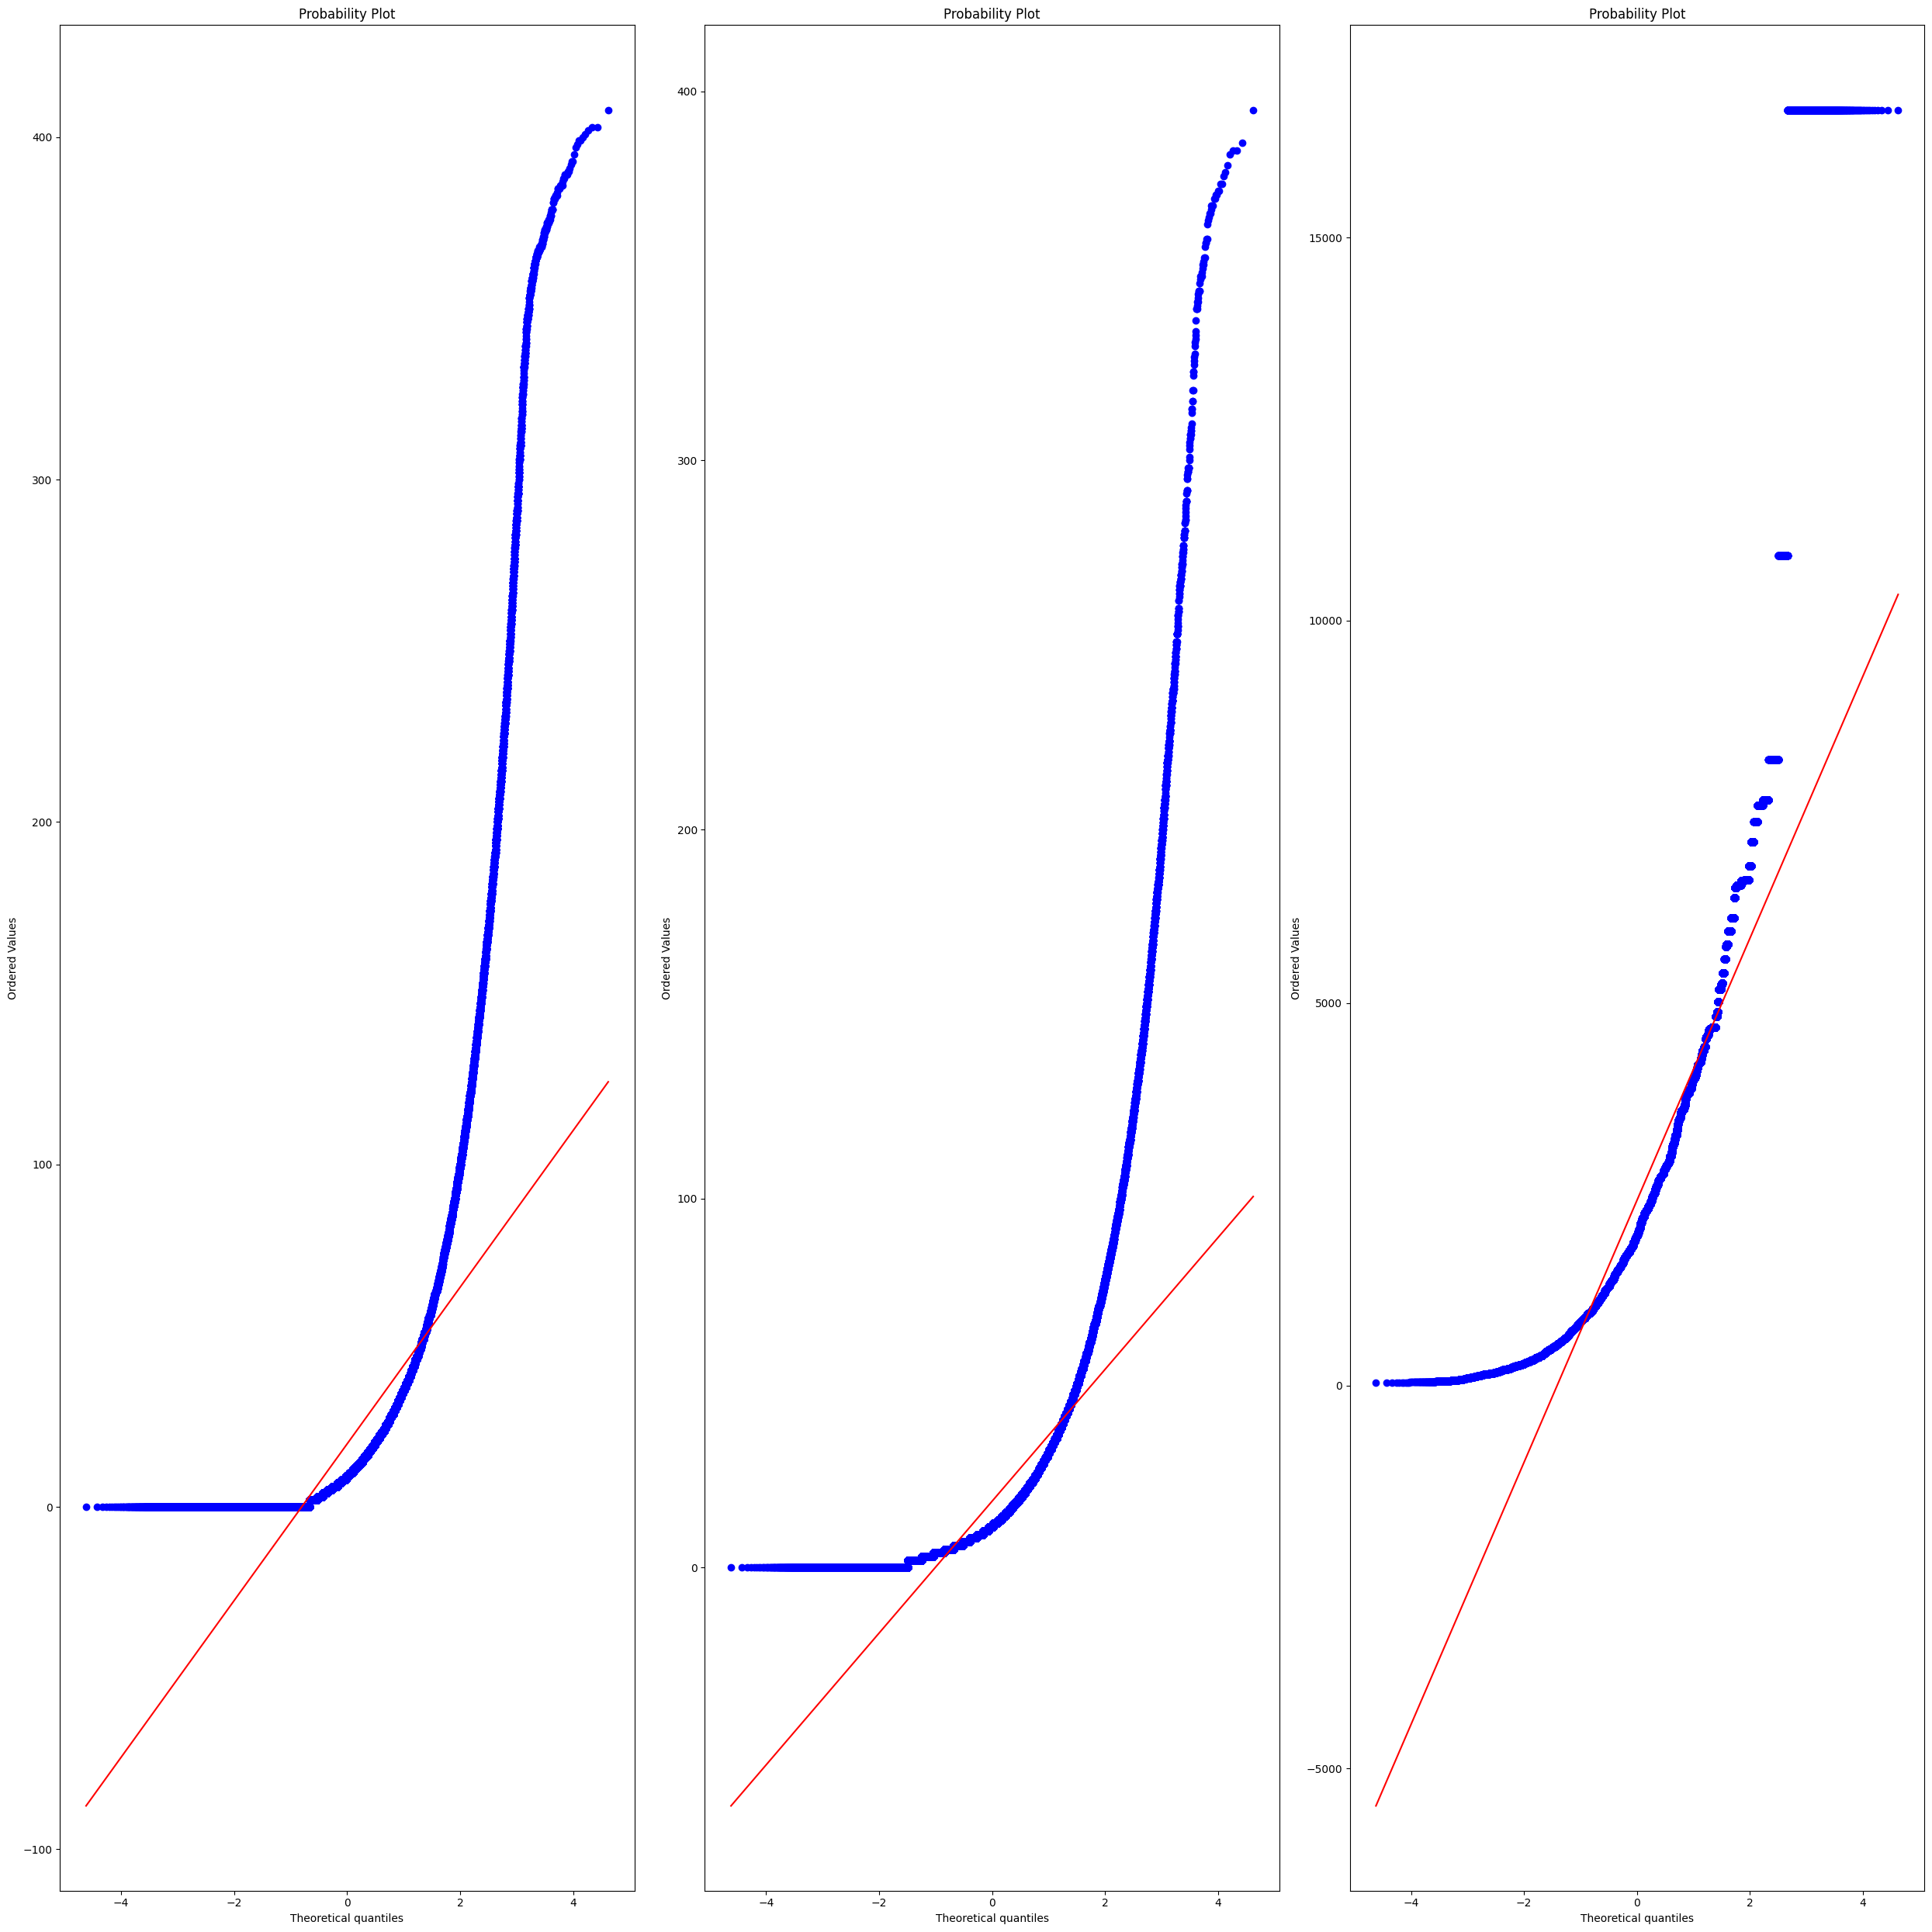

In [127]:
# Построим графики
plt.subplot(1, 3, 1) 
stats.probplot(data['review_total_negative_word_counts'], plot=plt) 

plt.subplot(1, 3, 2) 
stats.probplot(data['review_total_positive_word_counts'], plot=plt) 

plt.subplot(1, 3, 3) 
stats.probplot(data['total_number_of_reviews'], plot=plt) 

plt.tight_layout() # используем чтобы графики не наезжали другу на друга

plt.show() # просмотр графика 

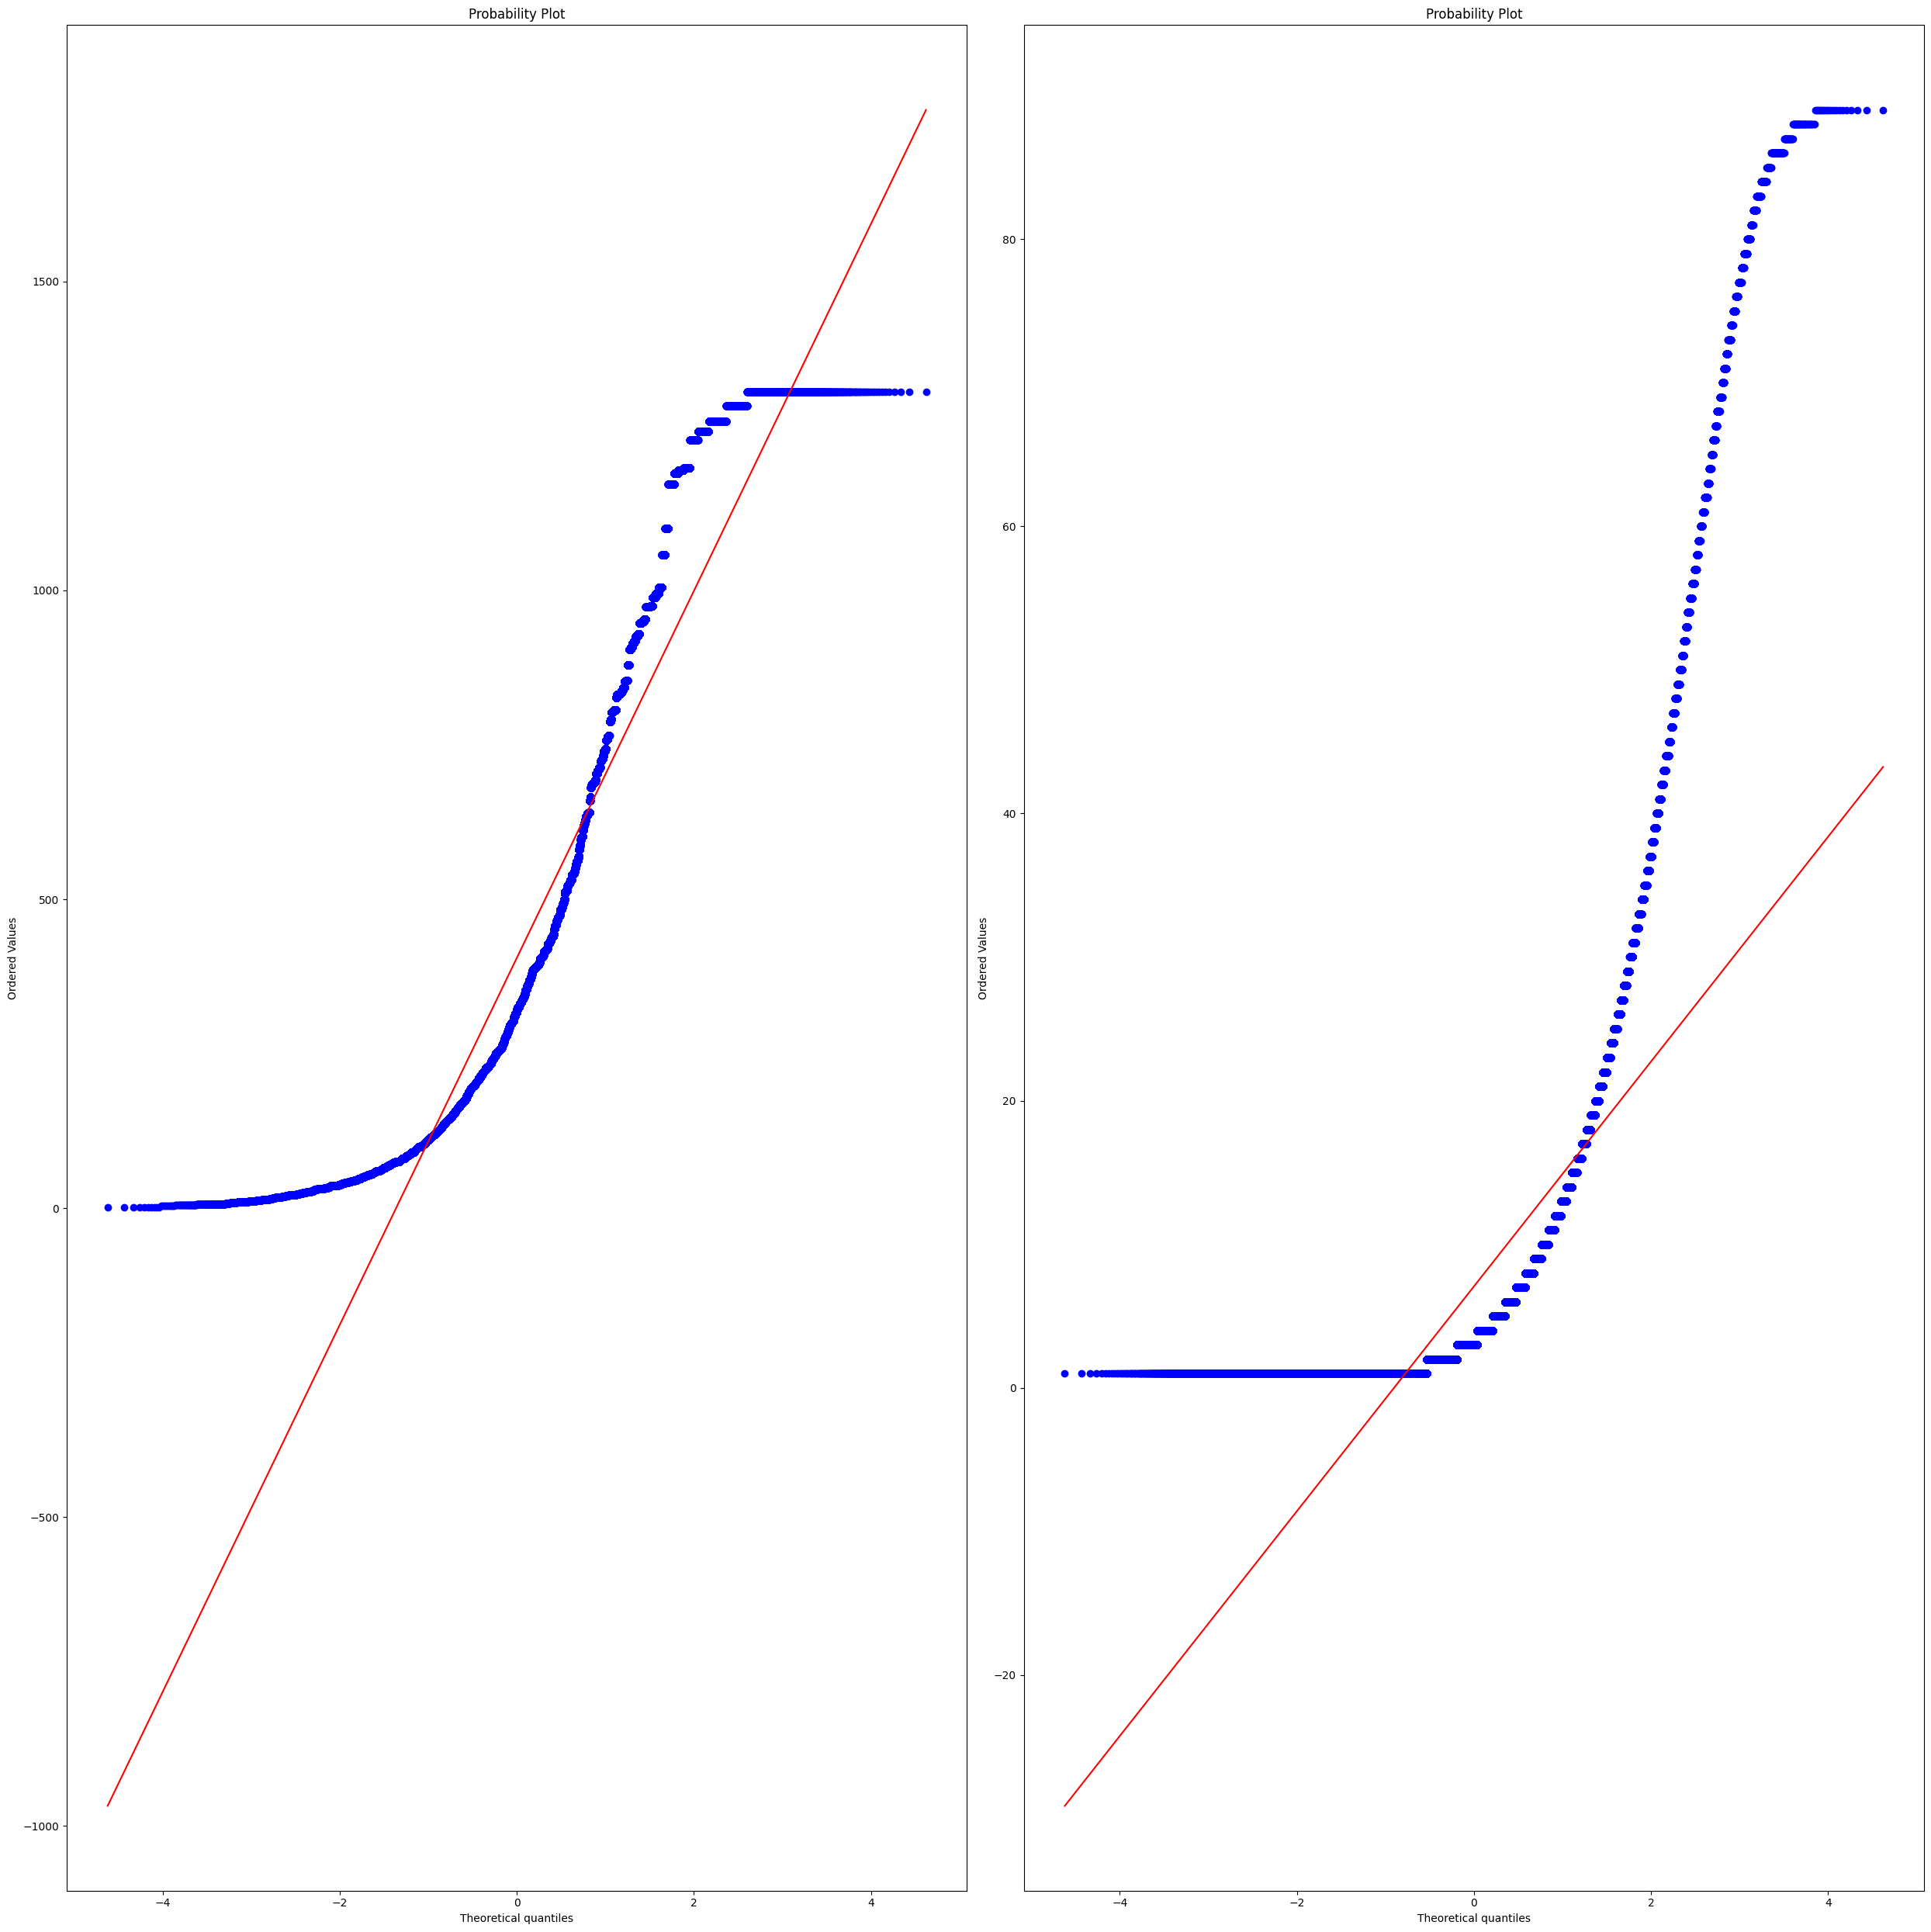

In [128]:
# Построим графики
plt.subplot(1, 2, 1) 
stats.probplot(data['additional_number_of_scoring'], plot=plt)

plt.subplot(1, 2, 2) 
stats.probplot(data['total_number_of_reviews_reviewer_has_given'], plot=plt) 

plt.tight_layout() # используем чтобы графики не наезжали другу на друга

plt.show() # просмотр графика 

Из графиков видно, что распределение не нормальное, поэтому для преобразования призновов используем нормализацию.

**Нормализация**

In [129]:
# Создадим список с числовыми признаками, которые мы хотим нормализовать
cols = [
    'review_total_negative_word_counts', 'review_total_positive_word_counts', 
    'total_number_of_reviews', 'additional_number_of_scoring', 'total_number_of_reviews_reviewer_has_given'
]
data[cols].describe() # смотрим на распределение данных

,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews,additional_number_of_scoring,total_number_of_reviews_reviewer_has_given
count,363627.000000,363627.000000,363627.000000,363627.000000,363627.000000
mean,18.397957,17.990947,2424.318890,405.187857,7.064330
std,29.598507,21.927850,1889.845692,314.077798,9.826833
min,0.000000,0.000000,43.000000,1.000000,1.000000
25%,0.000000,6.000000,1110.000000,161.000000,1.000000
50%,9.000000,11.000000,1969.000000,321.000000,3.000000
75%,23.000000,23.000000,3224.000000,562.000000,9.000000
max,408.000000,395.000000,16670.000000,1322.000000,89.000000


In [130]:
# Проводим нормализацию RobustScaler, так как в датасете есть выбросы
r_scaler = preprocessing.RobustScaler()
data[cols] = r_scaler.fit_transform(data[cols]) 

data[cols].describe() # смотрим на распределение данных

,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews,additional_number_of_scoring,total_number_of_reviews_reviewer_has_given
count,363627.000000,363627.000000,363627.000000,363627.000000,363627.000000
mean,0.408607,0.411232,0.215383,0.209945,0.508041
std,1.286892,1.289874,0.893967,0.783236,1.228354
min,-0.391304,-0.647059,-0.911069,-0.798005,-0.250000
25%,-0.391304,-0.294118,-0.406339,-0.399002,-0.250000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.608696,0.705882,0.593661,0.600998,0.750000
max,17.347826,22.588235,6.954115,2.496259,10.750000


Теперь данные распределены более нормально.

# Корреляция

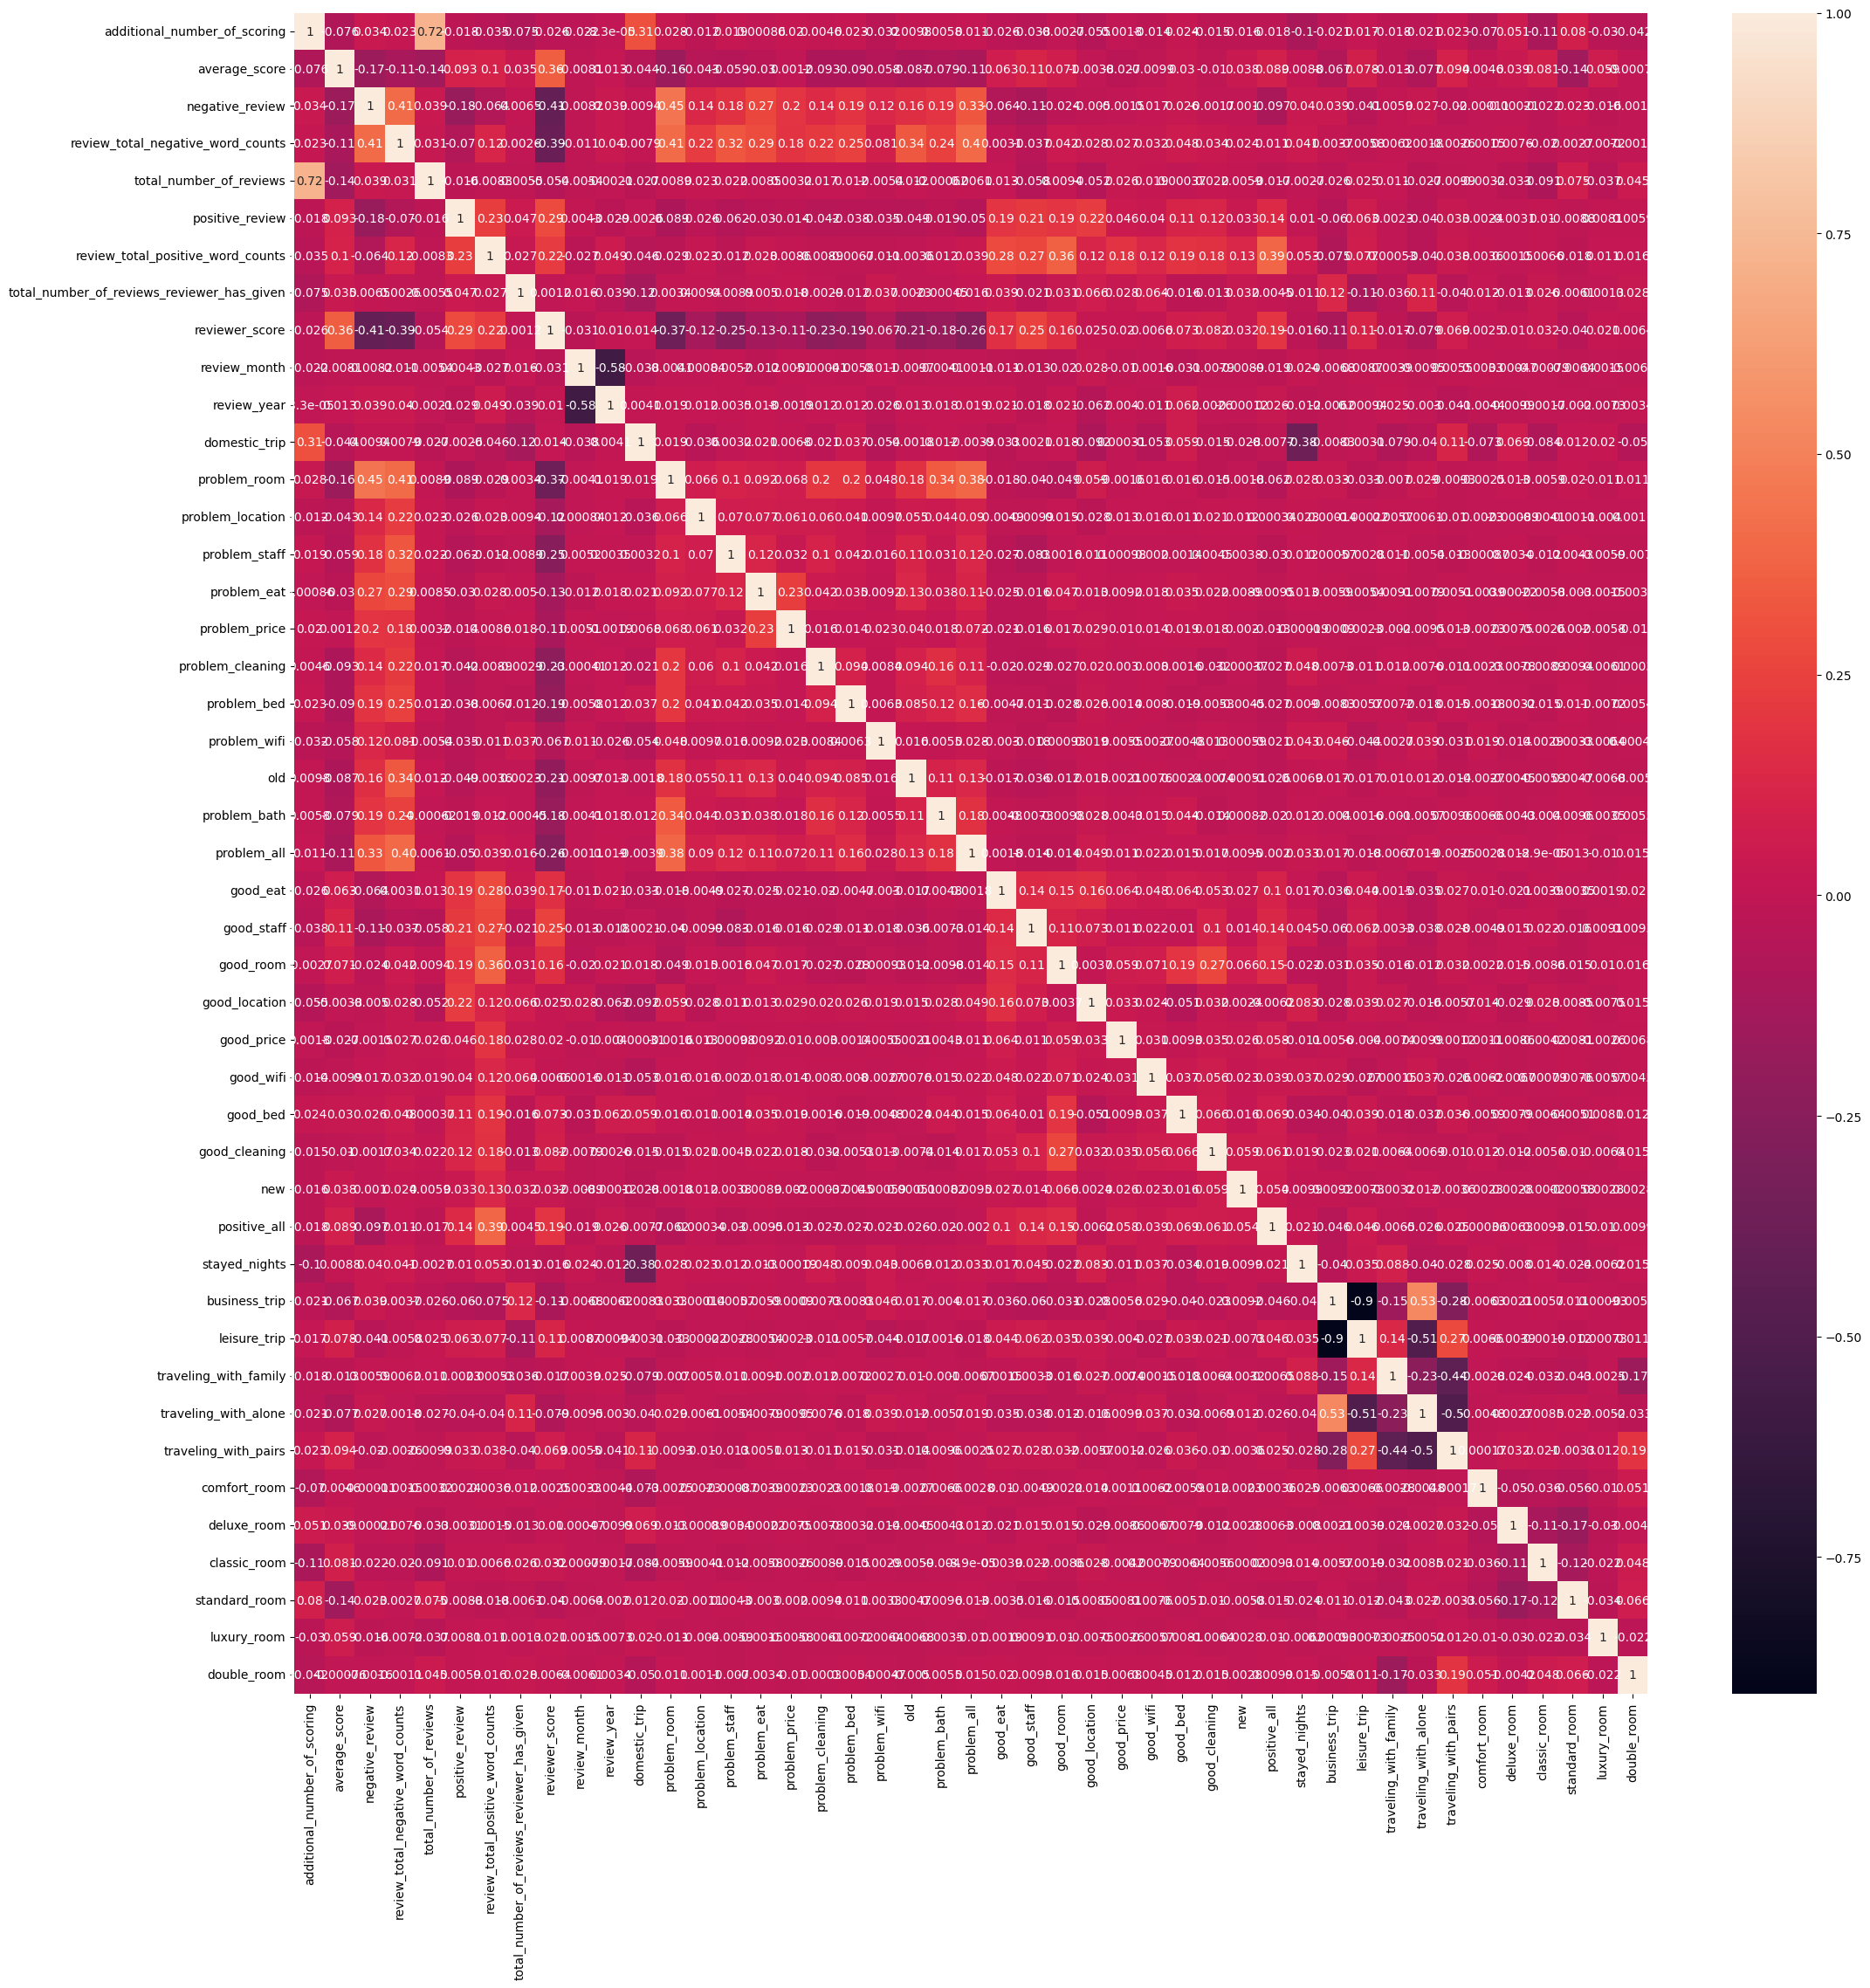

In [131]:
# Смотрим взаимосвязи между признаками. Чтобы не было мультиколлинеарность.
plt.rcParams['figure.figsize'] = (25,25)
sns.heatmap(data.corr(numeric_only=True), annot=True);

Мы наблюдаем высокую корреляцию между признаками "число оценок без проверки" и "общее число отзывов", а также между поездками для отдыха и бизнес.

In [132]:
# Удалим additional_number_of_scoring
data.drop(['additional_number_of_scoring'], axis=1, inplace=True)

# Удалим  leisure_trip
data.drop(['leisure_trip'], axis=1, inplace=True)

# Кодирование признаков

In [133]:
# Кодируем страну
bin_encoder = ce.BinaryEncoder(cols=['hotel_country']) 
type_bin = bin_encoder.fit_transform(data['hotel_country'])
data = pd.concat([data, type_bin], axis=1) # обновляем датасет

# Кодируем национальность
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) 
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1) # обновляем датасет

# Кодируем название отеля
bin_encoder = ce.BinaryEncoder(cols=['hotel_name']) 
type_bin = bin_encoder.fit_transform(data['hotel_name'])
data = pd.concat([data, type_bin], axis=1) # обновляем датасет

#  Исследование данных

In [134]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363627 entries, 0 to 363626
Data columns (total 71 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               363627 non-null  float64
 1   hotel_name                                  363627 non-null  object 
 2   reviewer_nationality                        363627 non-null  object 
 3   negative_review                             363627 non-null  int64  
 4   review_total_negative_word_counts           363627 non-null  float64
 5   total_number_of_reviews                     363627 non-null  float64
 6   positive_review                             363627 non-null  int64  
 7   review_total_positive_word_counts           363627 non-null  float64
 8   total_number_of_reviews_reviewer_has_given  363627 non-null  float64
 9   reviewer_score                              363627 non-null  float64
 

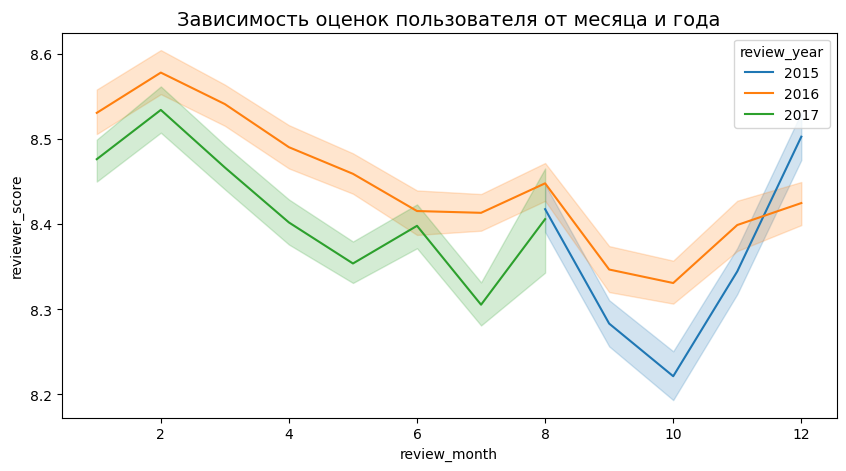

In [135]:
# Строим график зависимости оценок пользователяк от месяца и года
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

fig = sns.lineplot(
    data = data,
    x = 'review_month',
    y = 'reviewer_score',
    hue = 'review_year',
    palette = 'tab10'
)
ax.set_title('Зависимость оценок пользователя от месяца и года', fontdict={'size': 14});

Из графика видно, что люди ставят оценки выше в феврале - марте. Потом идет снижение. Самые низкие средние оценки ставят в сентябре - октябре. Предполагаю, что это связано с общим количеством отзывов по месяцам. Так как летом люди чаще путешествуют, то и отзывов, в том числе и отрицательных, ставят больше.

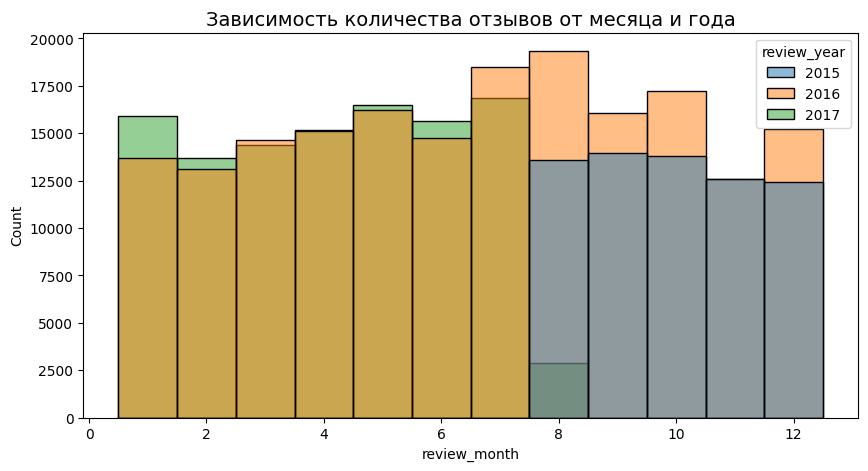

In [136]:
# Строим график зависимости количества оценок от месяца и года
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

fig = sns.histplot(
    data = data,
    x = 'review_month',
    hue = 'review_year',
    discrete=True,
    palette = 'tab10'
)
ax.set_title('Зависимость количества отзывов от месяца и года', fontdict={'size': 14});

Из графика видно, что больше всего отзывов оставляют в июль - август, это связано с тем, что чаще всего люди предпочитают брать отпуск и путешествовать летом, когда на улице хорошая погода. Меньше оставляют отзывов в ноябре, возможно это связано с плохой погодой и приближением конца года.

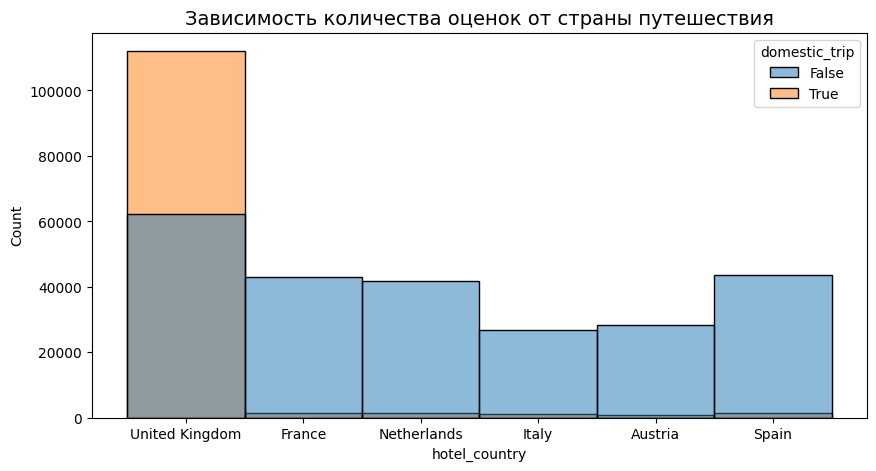

In [137]:
# Строим график зависимости количества оценок от страны путешествия и от того гражданин путешествует или нет
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

fig = sns.histplot(
    data = data,
    x = 'hotel_country',
    hue = 'domestic_trip',
    palette = 'tab10',
    discrete=True
)
ax.set_title('Зависимость количества оценок от страны путешествия', fontdict={'size': 14});

# True - человек путешествует внутри своей страны
# False - человек приехал из другой страны

Из графика по нашем данным видно, что чаще всего путешествуют в United Kingdom, при чем в большей степени это внутренние путешествия. В других странах внутри страны очень мало путешествуют, в основном ездят за границу.

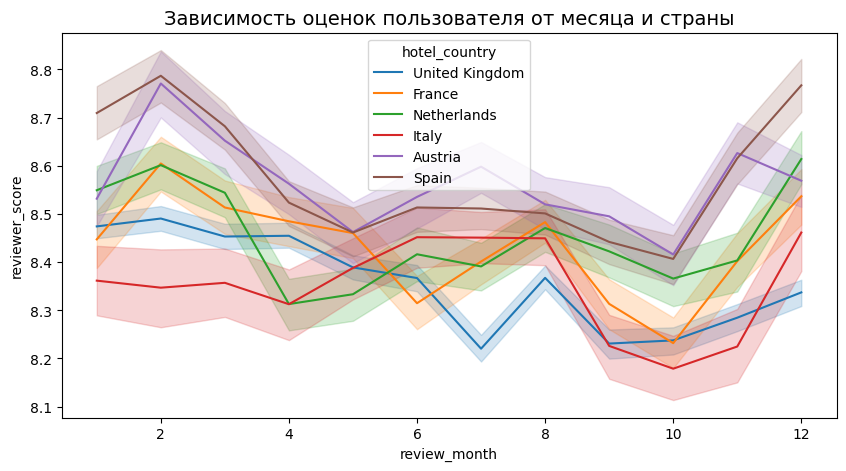

In [138]:
# Строим график зависимости оценок пользователя от страны путешествия и месяца
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

fig = sns.lineplot(
    data = data,
    x = 'review_month',
    y = 'reviewer_score',
    hue = 'hotel_country',
    palette = 'tab10'
)
ax.set_title('Зависимость оценок пользователя от месяца и страны', fontdict={'size': 14});

На графике видно, что в целом в любой стране средняя оценка ставится одинаковая в рамках 8.2-8.8. При этом наблюдается резкий рост оценки зимой в Austria и Spain. И United Kingdom и Italy более низкие оценки за отели в сравнении с другими странами. 

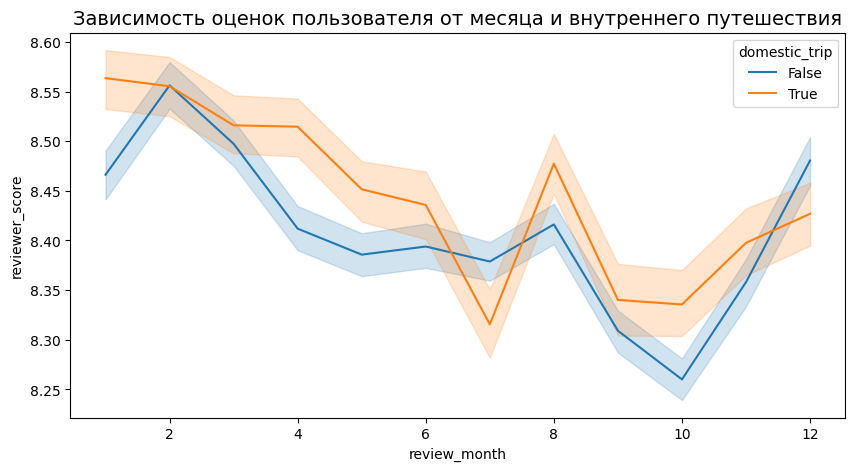

In [139]:
# Строим график зависимости оценок пользователя от страны путешествия и от того гражданин путешествует или нет
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

fig = sns.lineplot(
    data = data,
    x = 'review_month',
    y = 'reviewer_score',
    hue = 'domestic_trip',
    palette = 'tab10'
)
ax.set_title('Зависимость оценок пользователя от месяца и внутреннего путешествия', fontdict={'size': 14});

# True - человек путешествует внутри своей страны
# False - человек приехал из другой страны

Из графика видно, что,  люди путешествующие внутри страны, ставят оценку выше, чем приехавшие.

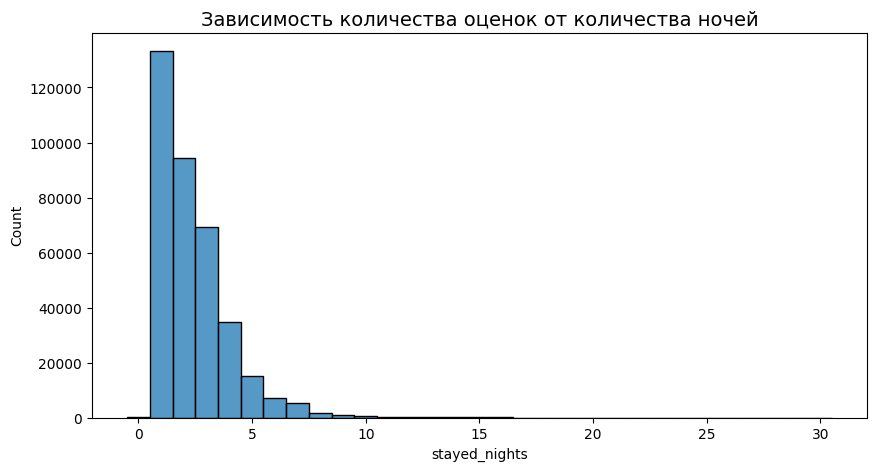

In [140]:
# Строим график зависимости количества оценок от количества ночей
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

fig = sns.histplot(
    data = data,
    x = 'stayed_nights',
    discrete=True
)
ax.set_title('Зависимость количества оценок от количества ночей', fontdict={'size': 14});

Из графика мы видим, что больше всего оставляют отзывы люди останавливающиеся на 1 ночь. Чем больше ночей проводят люди в отеле, тем меньше оставляют отзывов. Предполагаю, что это связано с тем, что большинство людей останавливаются на несколько дней. Следовательно, отзывов они будут оставлять больше. Но почему значительно больше отзывов оставляют люди остановившиеся на 1 ночь, на данный момент сказать не могу. Нужны дальнейшее исследования данных.

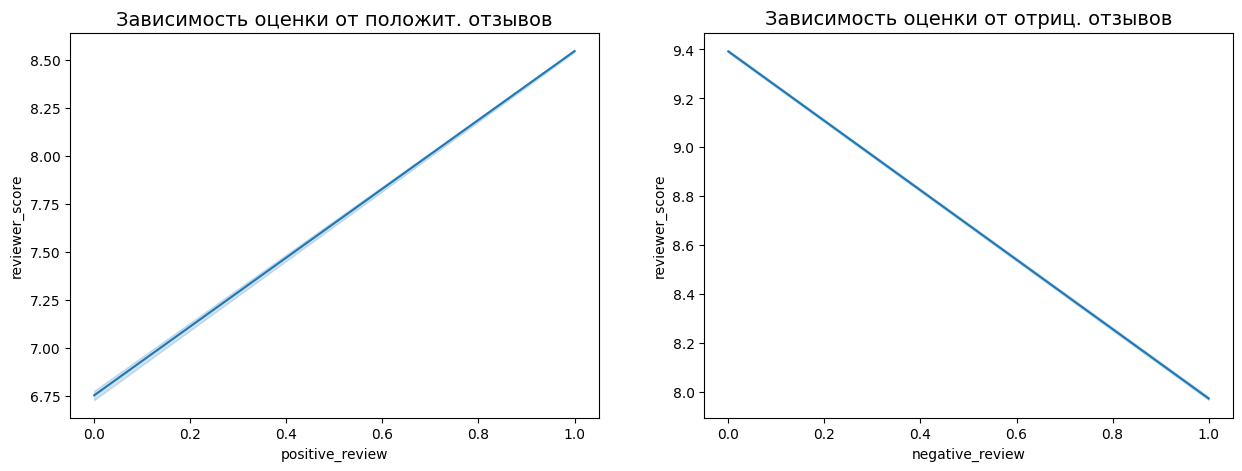

In [141]:
# Зависимость оценок пользователя от доли положительных и отрицательных отзывов
fig, (ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.lineplot(
    data=data, 
    x='positive_review', 
    y='reviewer_score', 
    ax=ax1[0])

sns.lineplot(
    data=data, 
    x='negative_review', 
    y='reviewer_score', 
    ax=ax1[1])

ax1[0].set_title('Зависимость оценки от положит. отзывов', fontdict={'fontsize': 14});
ax1[1].set_title('Зависимость оценки от отриц. отзывов', fontdict={'fontsize': 14});

Можем наблюдать на графиках, что отрицательные и положительные отзывы сильно влияют на оценку пользователя. Чем больше положительных отзывов, тем выше оценка, и чем больше отрицательных, тем ниже будет оценка.

**Гипотеза**

Нулевая гипотеза: нет значимой разницы между средней оценкой, которую рецензент поставил отелю и  средним баллом отеля.
Альтернативная гипотеза: есть значимая разница между средней оценкой, которую рецензент поставил отелю и  средним баллом отеля.

Для проверки гипотезы применю тест ANOVA

In [142]:
reviewer = data['reviewer_score']
average = data['average_score']

alpha = 0.05
_, p = f_oneway(reviewer, average)

H0 = 'Нет значимой разницы между средней оценкой, которую рецензент поставил отелю и средним баллом отеля'
H1 = 'Есть значимая разница между средней оценкой, которую рецензент поставил отелю и средним баллом отеля.'

if p>alpha:
  print(f'{p} > {alpha}. Мы не можем отвергнуть нулевую гипотезу. {H0}')
else:
  print(f'{p} <= {alpha}. Мы отвергаем нулевую гипотезу. {H1}')


0.07518402715456596 > 0.05. Мы не можем отвергнуть нулевую гипотезу. Нет значимой разницы между средней оценкой, которую рецензент поставил отелю и средним баллом отеля


Вывод: Согласно ANOVA тесту мы не можем отвергнуть нулевую гипотезу. Нет значимой разницы между средней оценкой, которую рецензент поставил отелю и средним баллом отеля. Следовательно, средний балл отеля влияет на оценку, которую выставляет посетитель.

# Финальная подготавка данных для модели

In [143]:
# Заменим булевые значения в признаке domestic_trip на числа 0 и 1
data['domestic_trip'] = data['domestic_trip'].replace(True,1)
data['domestic_trip'] = data['domestic_trip'].replace(False,0)

In [144]:
# убираем признаки "object", 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

# **3. Обучение модели**

# Отбор признаков

Проведем тесты, чтобы определить, какие признаки являются важными в обучении модели.

In [145]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = data.drop(['reviewer_score'], axis = 1)  
y = data['reviewer_score'] 

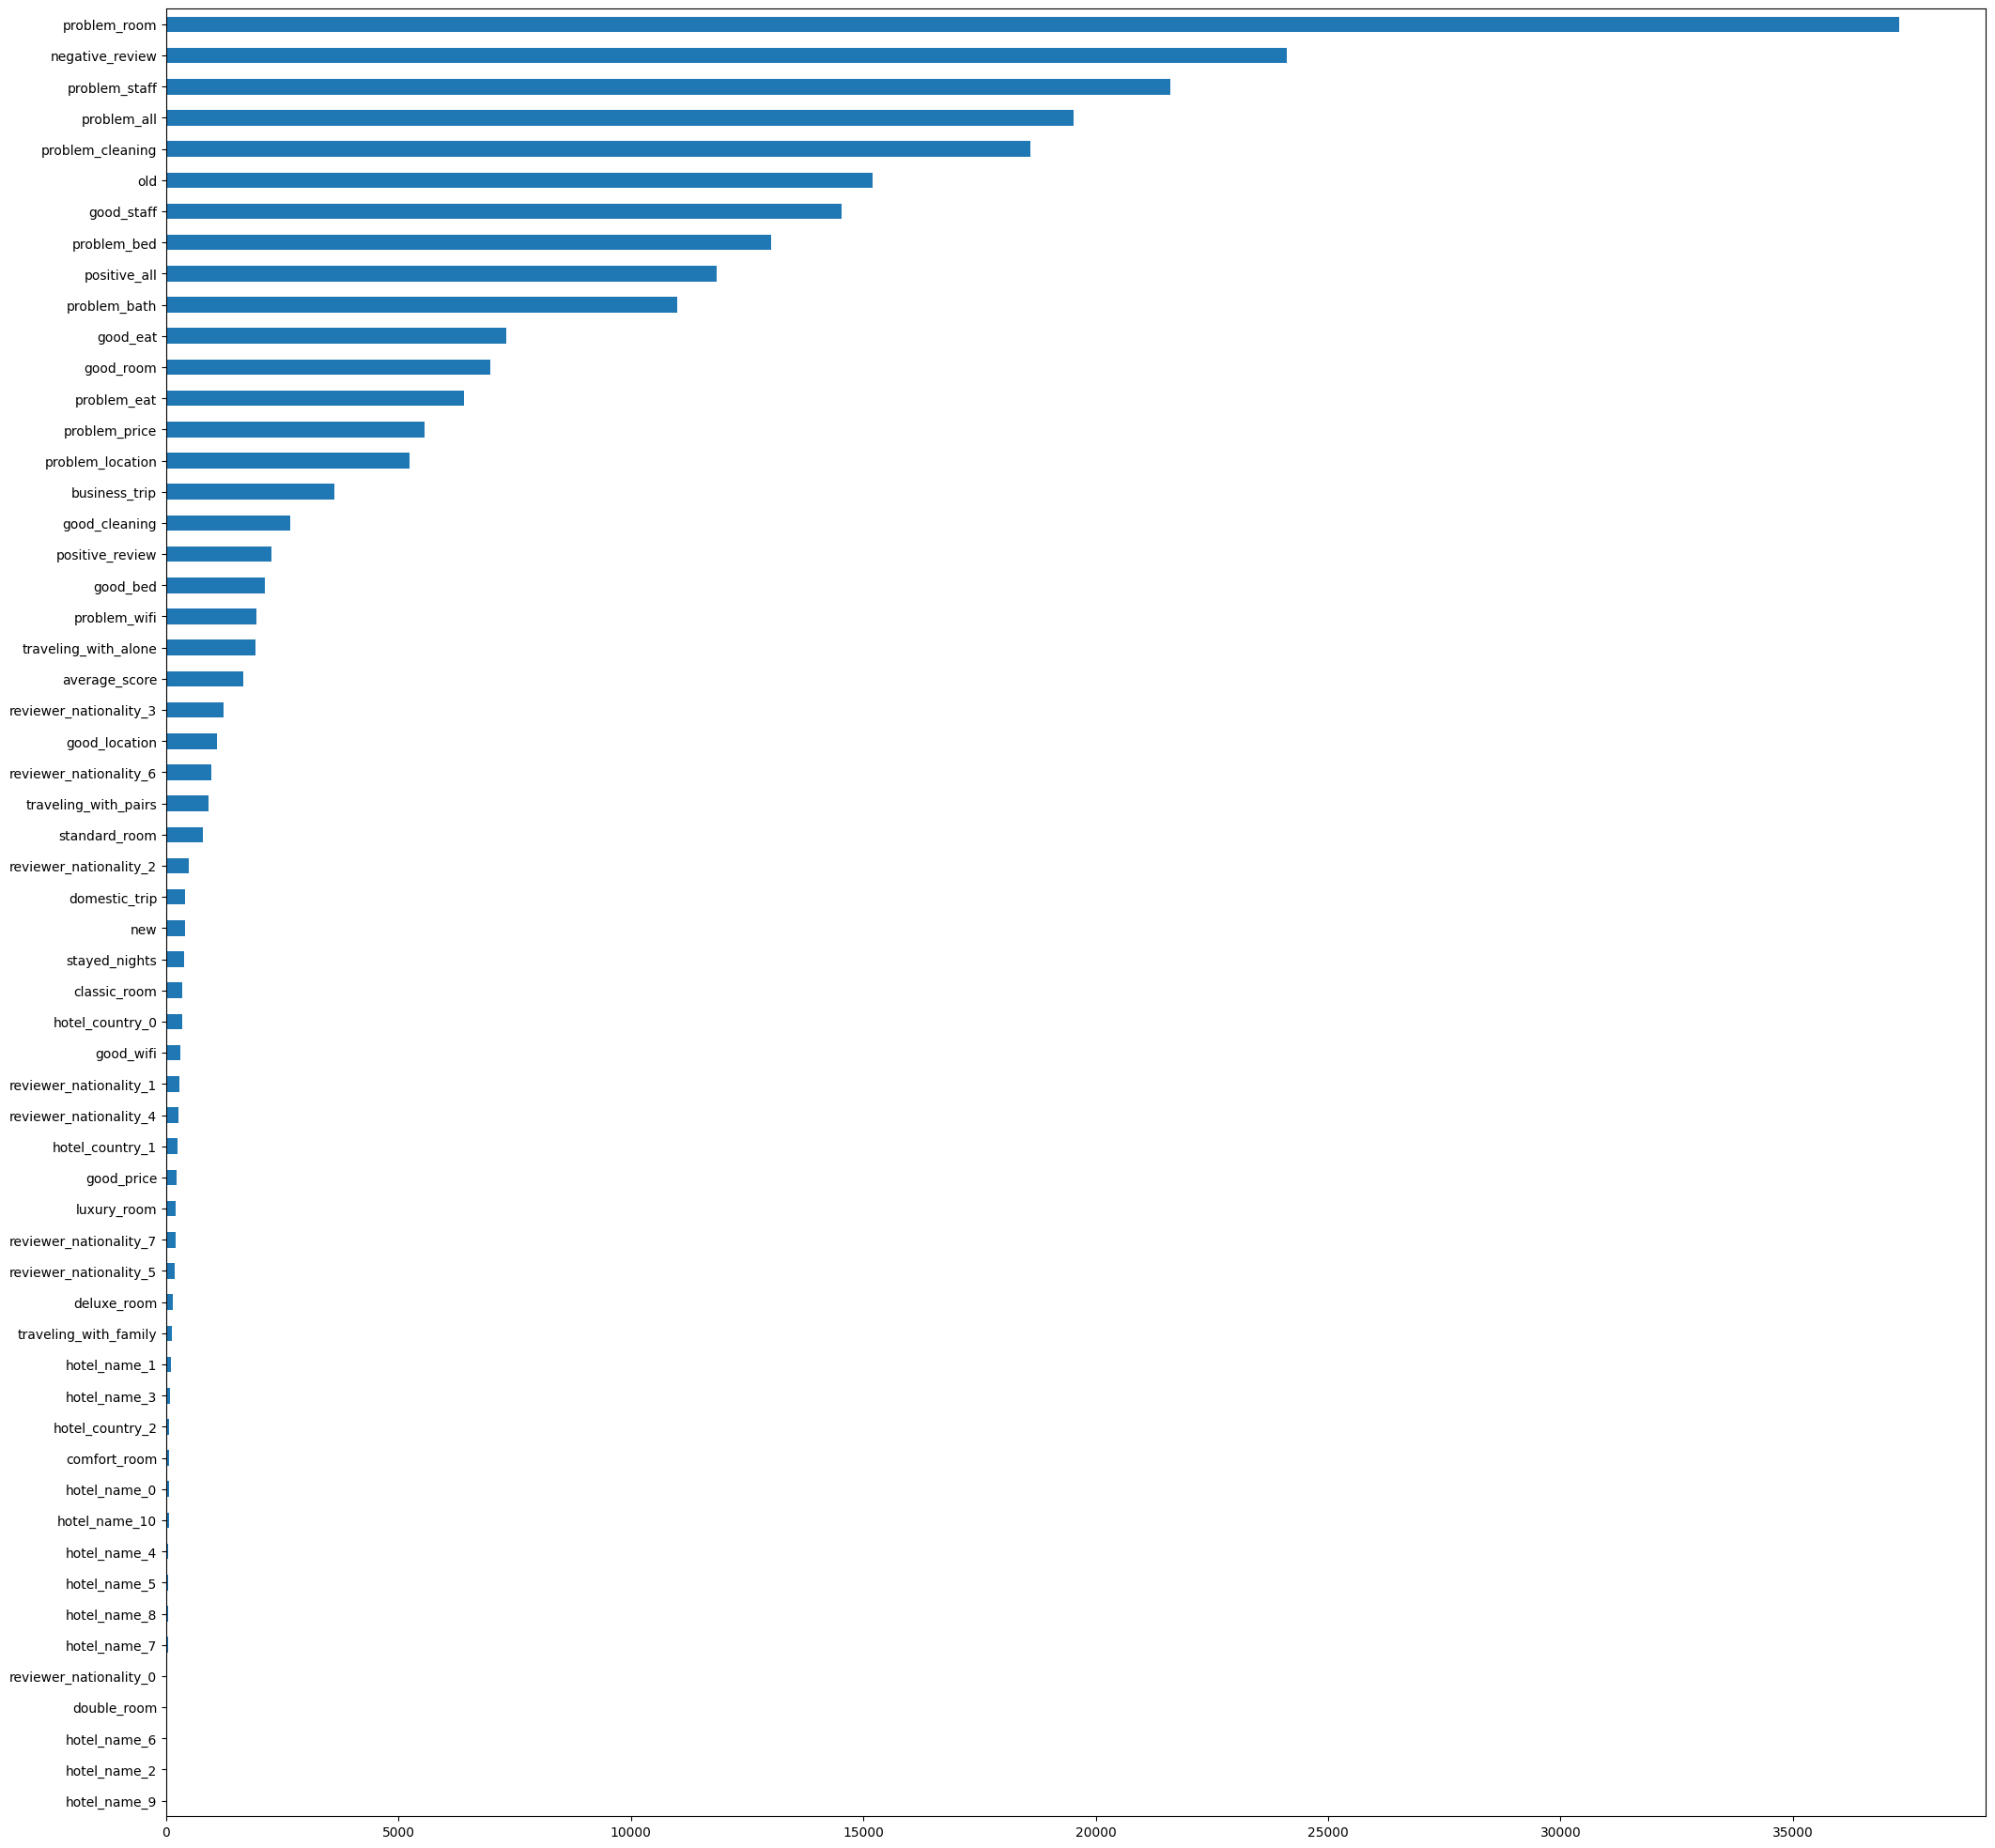

In [146]:
# Категориальные признаки
cat_cols = [
    'average_score', 'problem_room', 'problem_location', 'problem_staff', 'problem_eat', 'problem_price', \
    'negative_review', 'good_eat', 'good_staff', 'good_room', 'good_location', 'good_price', \
    'positive_review', 'business_trip', 'stayed_nights', 'domestic_trip', 'hotel_country_0', \
    'hotel_country_1','hotel_country_2','reviewer_nationality_0', 'reviewer_nationality_1','reviewer_nationality_2',\
    'reviewer_nationality_3','reviewer_nationality_4','reviewer_nationality_5','reviewer_nationality_6',\
    'reviewer_nationality_7','hotel_name_0','hotel_name_1','hotel_name_2','hotel_name_3','hotel_name_4',\
    'hotel_name_5','hotel_name_6','hotel_name_7','hotel_name_8','hotel_name_9','hotel_name_10', 'traveling_with_family', \
    'traveling_with_alone', 'traveling_with_pairs', 'problem_cleaning','problem_bed', 'problem_wifi', \
    'good_wifi', 'good_bed', 'good_cleaning', 'new', 'old', 'сomfort_room', 'deluxe_room', \
    'сlassic_room', 'standard_room', 'luxury_room', 'double_room', 'problem_bath', 'problem_all', 'positive_all'
]

y=y.astype('int')
# Проанализируем важность категориальных признаков
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

In [149]:
# Уберем малозначимые признаки
X.drop([
    'hotel_name_0','hotel_name_2','hotel_name_3', 'hotel_name_5', \
    'hotel_name_6','hotel_name_7','hotel_name_8','hotel_name_9','hotel_name_10', 'reviewer_nationality_0', \
    'reviewer_nationality_1','reviewer_nationality_2', 'reviewer_nationality_4', \
    'hotel_country_0', 'hotel_country_1','hotel_country_2', 'good_price', 'double_room', 'сomfort_room'
], axis=1, inplace=True)

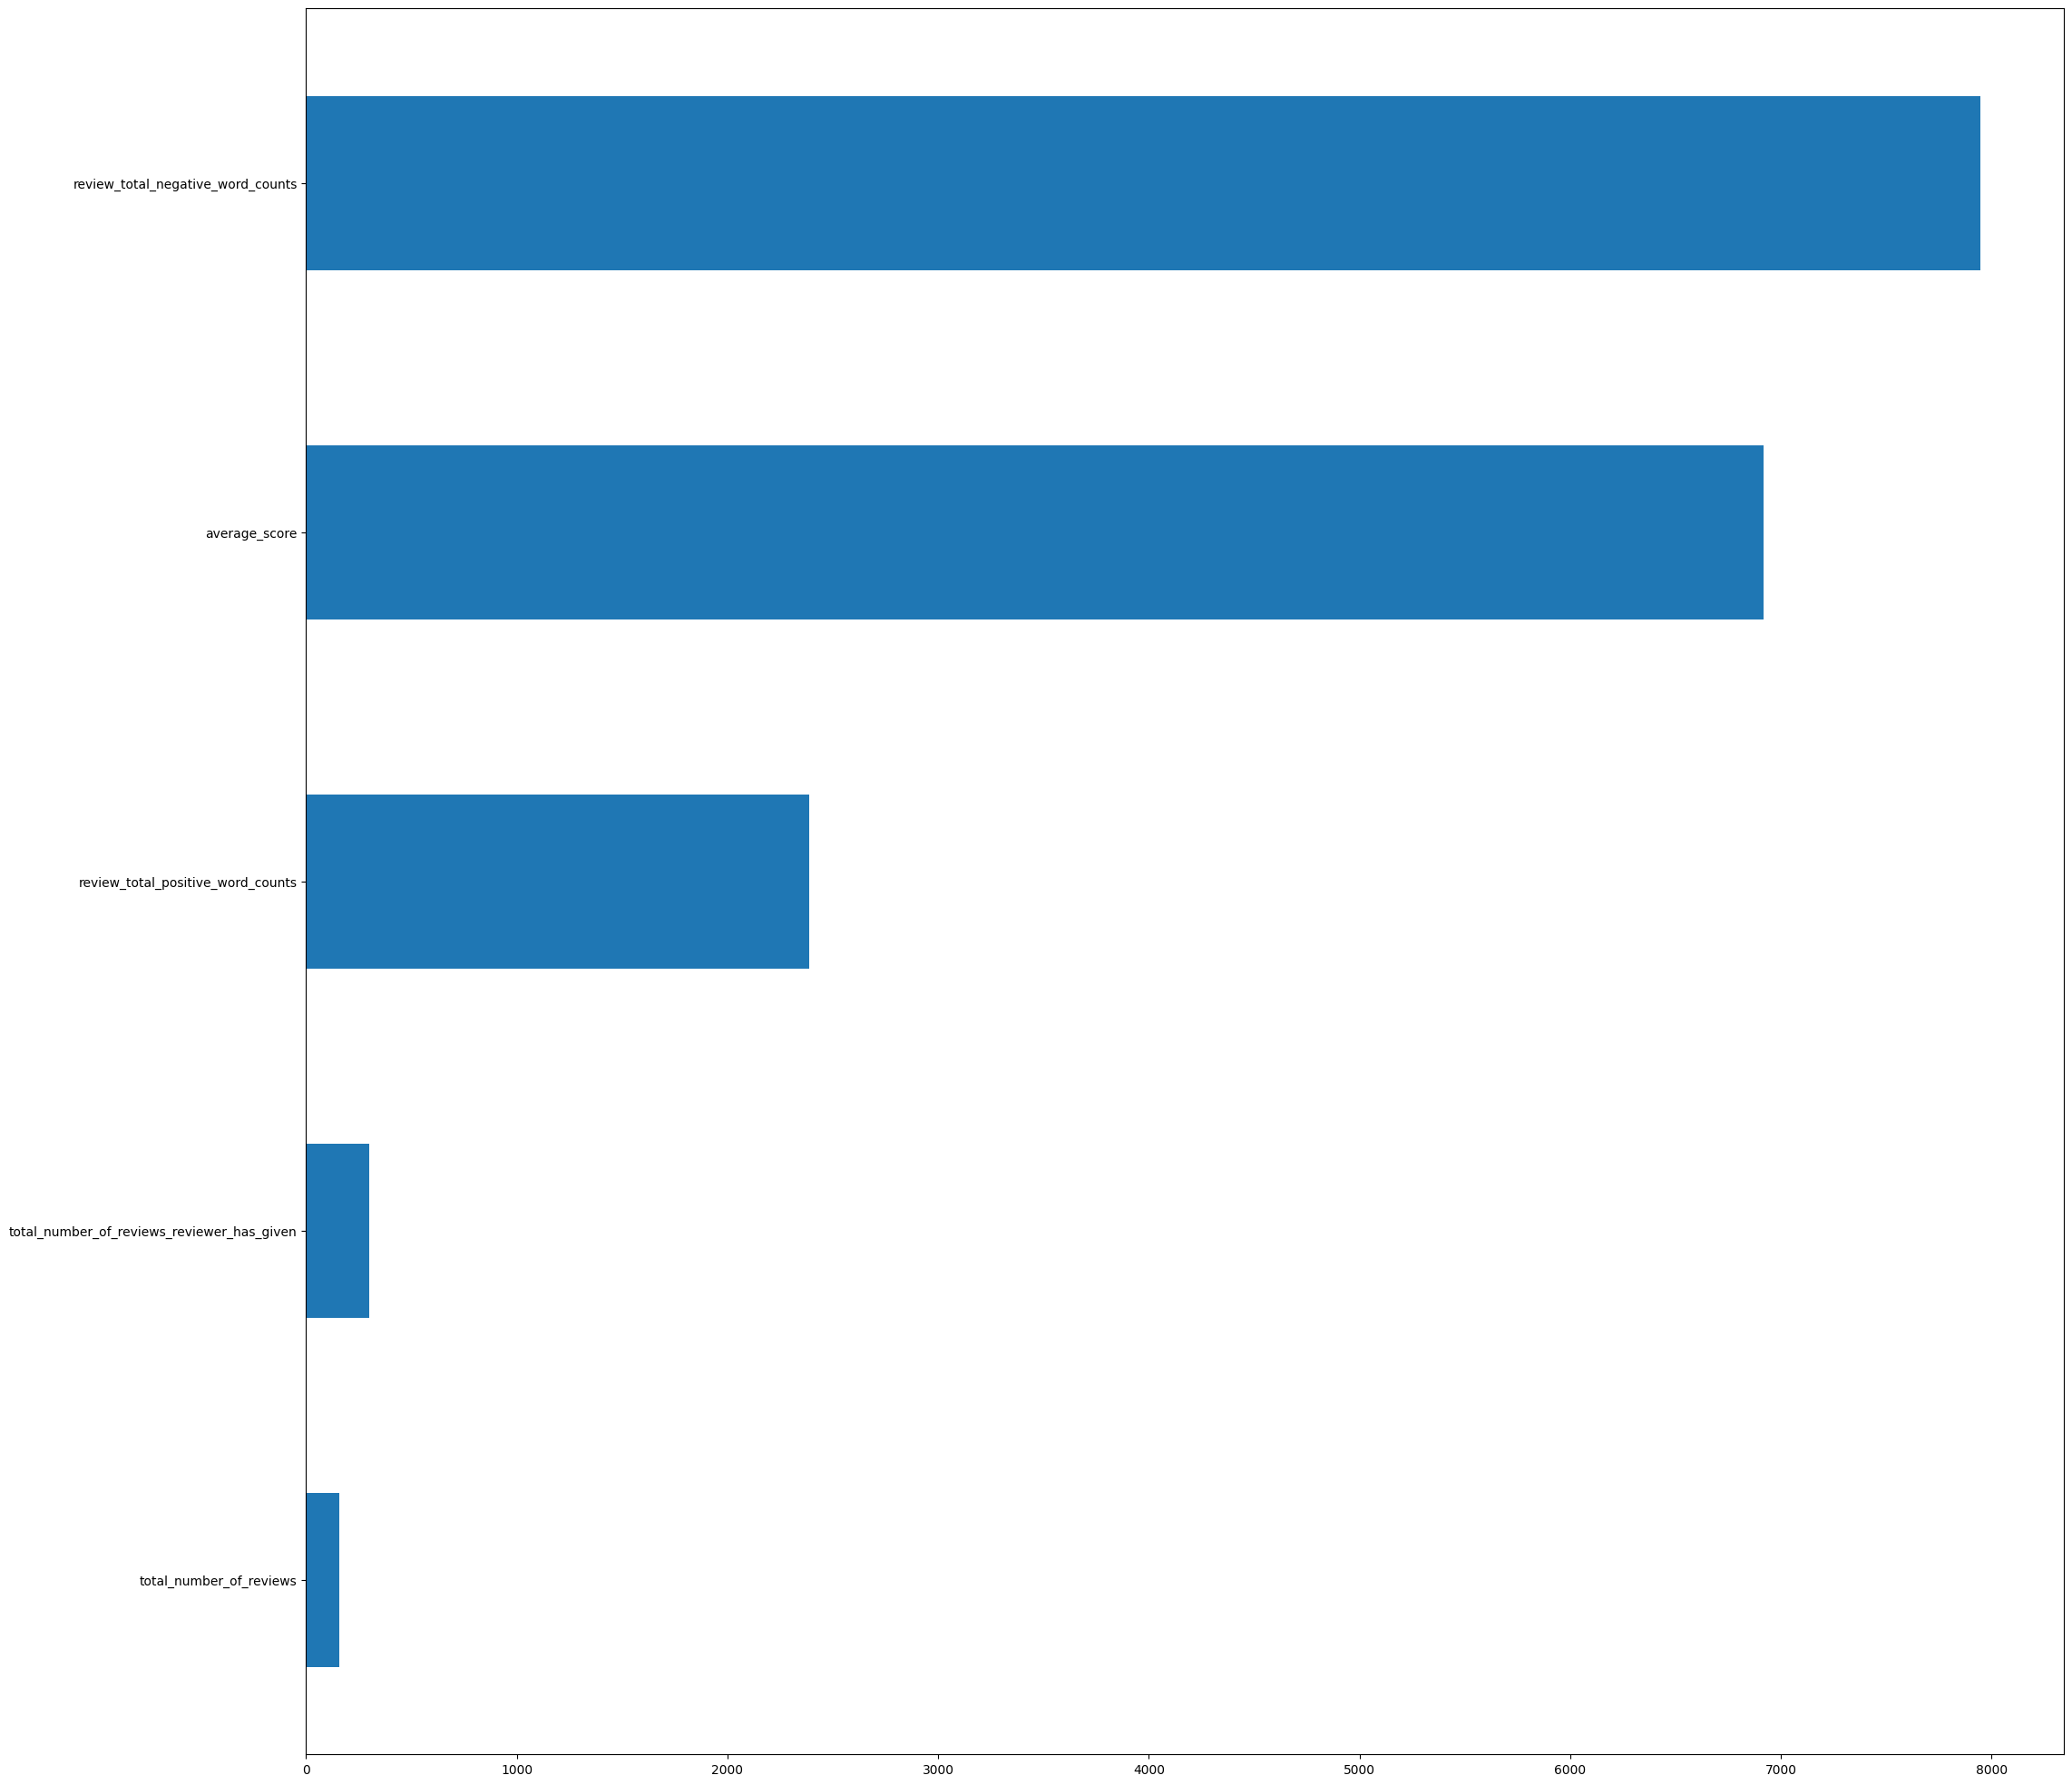

In [150]:
# Непрерывные признаки
num_cols = [
    'total_number_of_reviews', 'review_total_negative_word_counts', 'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given', 'average_score'
]
# average_score проверила в категориальных признаках, так было написано в примере в юнете, а так же
# решила проверить в непрерывных, так как данное число должно постепенно меняться 

# Проанализируем важность непрерывных признаков
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

In [151]:
# Уберем малозначимые признаки
X.drop(['total_number_of_reviews'], axis=1, inplace=True)

# Построение модели

In [152]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [154]:
# проверяем
y_train.shape, y_test.shape, X.shape, X_train.shape, X_test.shape

((290901,), (72726,), (363627, 44), (290901, 44), (72726, 44))

In [155]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [156]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [157]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    7.4s finished


In [158]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.9726715959642389


<AxesSubplot: >

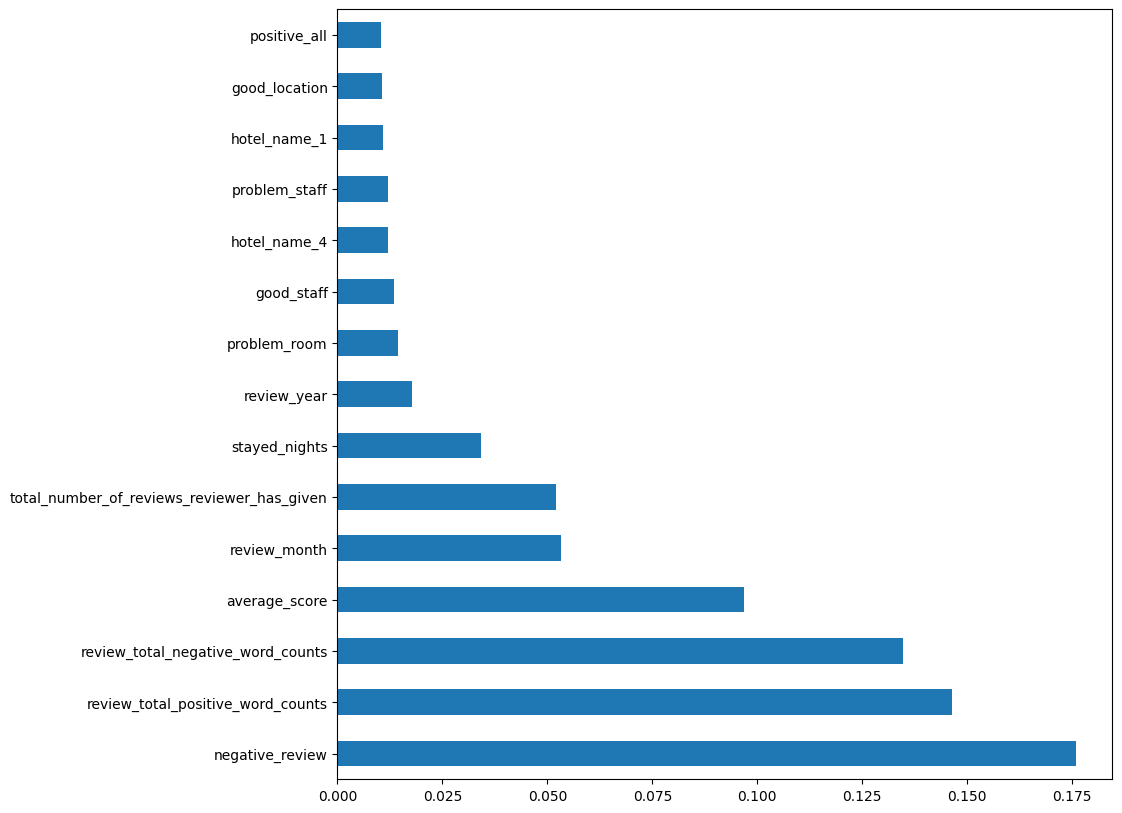

In [159]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [162]:
# pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
